In [1]:
# Standard Libraries
import re
import time
import string
import numpy as np
import pandas as pd
from collections import Counter

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
sns.set(style="white")

# Text Preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, TreebankWordTokenizer
from nltk.stem import WordNetLemmatizer, PorterStemmer, SnowballStemmer
from tqdm import tqdm
import gensim
from gensim.models import Word2Vec

# Feature Extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Model Evaluation & Utilities
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score
from sklearn.utils import resample, class_weight
from sklearn.utils.class_weight import compute_class_weight

# Scikit-learn Models
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

# PyTorch Core
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Subset, Dataset

# Transformers (Hugging Face)
from transformers import (
    DistilBertTokenizer, DistilBertTokenizerFast, DistilBertModel,
    DistilBertForSequenceClassification, BertTokenizer, BertModel,
    Trainer, TrainingArguments, AutoTokenizer, AutoModel
)

# Sentence Transformers
from sentence_transformers import SentenceTransformer

# TensorFlow / Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l2
from keras.losses import CategoricalFocalCrossentropy, SparseCategoricalCrossentropy
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.layers import ReLU


c:\Users\ruben\.conda\envs\DeepLearning2425\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#!pip install wordcloud
#!pip install nltk
#!pip install strings
#!pip install transformers
#!pip install torch
#!pip install -U sentence-transformers

In [3]:
# Load the datasets
df_train = pd.read_csv('../Data/train.csv')
df_test = pd.read_csv('../Data/test.csv')

<a class="anchor" id="chapter2"></a>

# 2. Data Exploration

</a>

- The only values in label are 0,1 and 2
- There are no missing values on both datasets;
- There are no duplicates on both datasets;

In [4]:
# Check the test set
print(df_test.shape)
df_test.head()

(2388, 2)


,id,text
0,0,ETF assets to surge tenfold in 10 years to $50...
1,1,Here’s What Hedge Funds Think Evolution Petrol...
2,2,$PVH - Phillips-Van Heusen Q3 2020 Earnings Pr...
3,3,China is in the process of waiving retaliatory...
4,4,"Highlight: “When growth is scarce, investors s..."


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9543 entries, 0 to 9542
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    9543 non-null   object
 1   label   9543 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 149.2+ KB


In [6]:
# Set id as index
df_test.set_index('id', inplace=True)

In [7]:
# Check the train set
print(df_train.shape)
df_train.head()

(9543, 2)


,text,label
0,$BYND - JPMorgan reels in expectations on Beyo...,0
1,$CCL $RCL - Nomura points to bookings weakness...,0
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0
3,$ESS: BTIG Research cuts to Neutral https://t....,0
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0


In [8]:
# Check null values
print(f"Null values in labels = {df_train['label'].isna().sum()}")
print(f"Null values in text = {df_train['text'].isna().sum()}")

Null values in labels = 0
Null values in text = 0


In [9]:
# Check for missing values
print("Missing values in train dataset:")
print(df_train.isnull().sum())
print("\nMissing values in test dataset:")
print(df_test.isnull().sum())

Missing values in train dataset:
text     0
label    0
dtype: int64

Missing values in test dataset:
text    0
dtype: int64


In [10]:
# Check for duplicates
print("Duplicates in train dataset:", df_train.duplicated().sum())
print("Duplicates in test dataset:", df_test.duplicated().sum())

Duplicates in train dataset: 0
Duplicates in test dataset: 0


<a class="anchor" id="sub-section-2_1"></a>

## 2.1. Labels

</a>

The average sentiment label in the training dataset is ~1.50, which suggests a **slight tendency toward positive or neutral sentiment**. Since the labels are categorical — Bearish (0), Bullish (1), and Neutral (2) — this average doesn’t map to a real sentiment but indicates that Bearish tweets are less frequent compared to Bullish and Neutral ones

In [11]:
label_counts = df_train['label'].value_counts().sort_index()
label_percent = round(df_train['label'].value_counts(normalize=True) * 100,1)

In [12]:
# get value counts for label
print("Label distribution in train dataset:")
print(label_counts)

# get value counts for label in percentage
print("Label distribution in train dataset (percentage):")
print(label_percent)

Label distribution in train dataset:
label
0    1442
1    1923
2    6178
Name: count, dtype: int64
Label distribution in train dataset (percentage):
label
2    64.7
1    20.2
0    15.1
Name: proportion, dtype: float64


In [13]:
# Check that labels are only 0,1, or 2
df_train['label'].unique()

array([0, 1, 2], dtype=int64)

In [14]:
print(f'Unique labels: {df_train["label"].unique()}')
df_train["label"].describe()

Unique labels: [0 1 2]


count    9543.000000
mean        1.496280
std         0.743139
min         0.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         2.000000
Name: label, dtype: float64

In [15]:
# Get the label mean
label_mean = df_train['label'].mean()
print(f'Our training set has a mean of {round(label_mean,1)}')

Our training set has a mean of 1.5


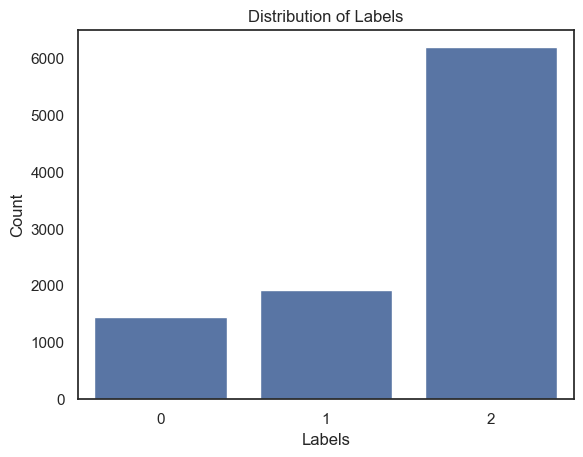

In [16]:
# Visualize distribution of labels
sns.countplot(data=df_train, x='label')
plt.title("Distribution of Labels")
plt.xlabel("Labels")
plt.ylabel("Count")
plt.show()

<Axes: ylabel='label'>

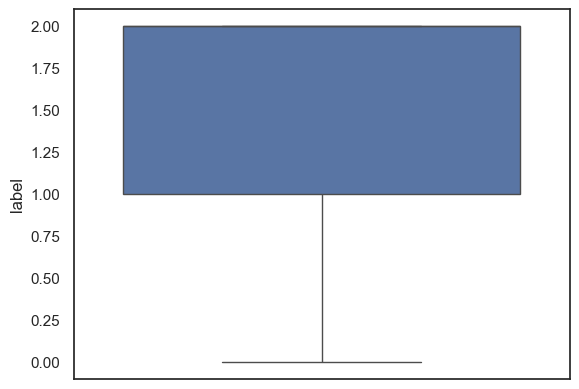

In [17]:
sns.boxplot(data=df_train['label'])

<a class="anchor" id="sub-section-2_2"></a>

## 2.2. Text

</a>

`Key Findings` <br>

The average tweet length in the dataset is approximately 86 characters and 12 words.

Most tweets are fairly short, with 75% under 120 characters and under 15 words.

The shortest tweet has just 2 characters, and the longest reaches 190 characters or 32 words.

This confirms that the dataset fits the typical tweet format and is well-suited for models like RNNs, LSTMs, or Transformers that handle short text.

These findings will also help in setting padding/truncation parameters during preprocessing (e.g., max_len = 32 or max_len = 40 to be safe).

In [18]:
# Fetch wordcount and character count for each abstract
df_train['word_count'] = df_train['text'].str.split().apply(len)
df_train['char_count'] = df_train['text'].str.len()

df_train[['text','word_count', 'char_count']].head()

,text,word_count,char_count
0,$BYND - JPMorgan reels in expectations on Beyo...,10,77
1,$CCL $RCL - Nomura points to bookings weakness...,14,102
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",14,94
3,$ESS: BTIG Research cuts to Neutral https://t....,7,59
4,$FNKO - Funko slides after Piper Jaffray PT cu...,10,71


In [19]:
df_train[['char_count', 'word_count']].describe()

,char_count,word_count
count,9543.000000,9543.000000
mean,85.858325,12.178351
std,35.138568,4.665599
min,2.000000,1.000000
25%,58.000000,9.000000
50%,79.000000,11.000000
75%,120.000000,15.000000
max,190.000000,32.000000


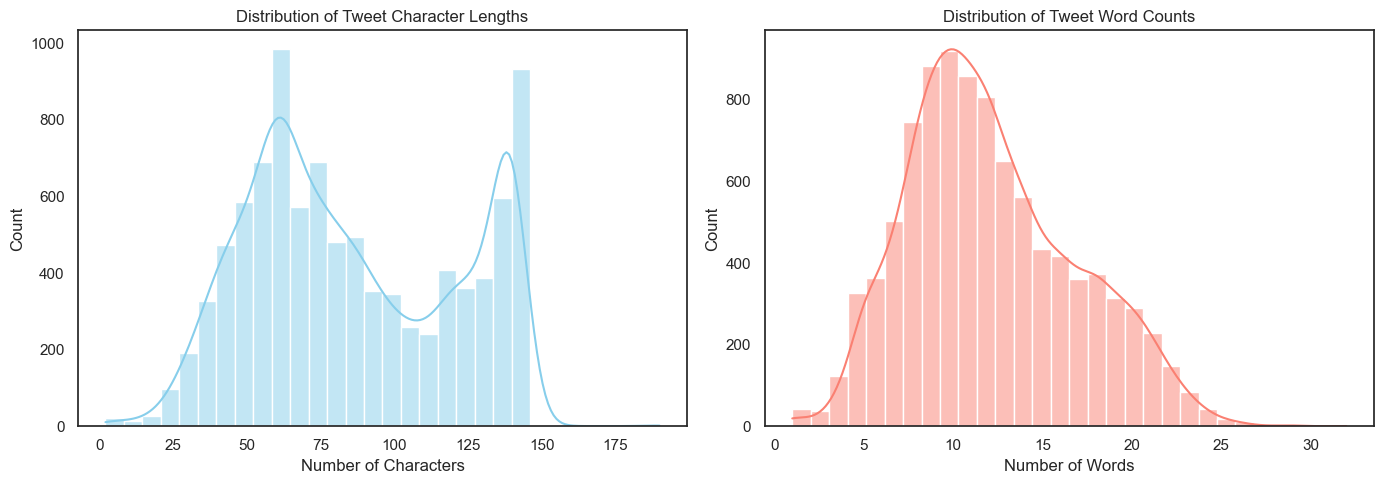

In [20]:
# Plot histograms
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Character count
sns.histplot(df_train['char_count'], bins=30, ax=axes[0], color='skyblue', kde=True)
axes[0].set_title('Distribution of Tweet Character Lengths')
axes[0].set_xlabel('Number of Characters')

# Word count
sns.histplot(df_train['word_count'], bins=30, ax=axes[1], color='salmon', kde=True)
axes[1].set_title('Distribution of Tweet Word Counts')
axes[1].set_xlabel('Number of Words')

plt.tight_layout()
plt.show()

In [21]:
all_words = ' '.join(df_train['text']).split()
freq = pd.Series(all_words).value_counts()
freq.sort_values(ascending=False)[0:10]

to     2332
the    1820
of     1464
-      1390
in     1361
on     1136
for    1032
a       970
and     898
The     663
Name: count, dtype: int64

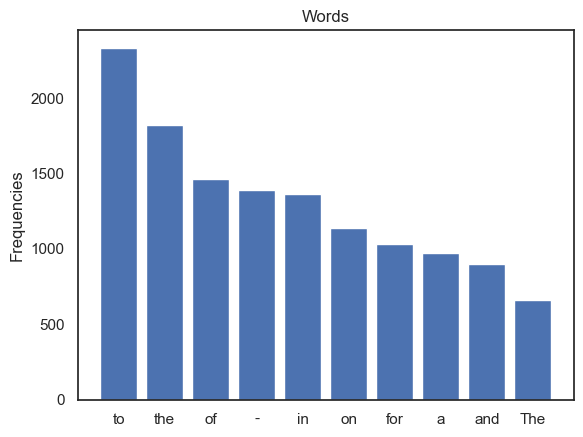

In [22]:
x_labels = freq.index[0:10]
values = freq[:10]
plt.bar(x_labels, values, align='center')
plt.xticks(x_labels)
plt.ylabel('Frequencies')
plt.title('Words')
plt.xticks(rotation=0)
plt.show()

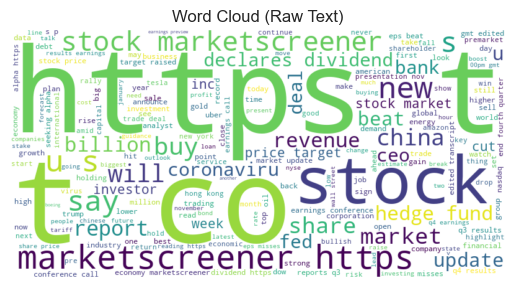

In [23]:
# Create a word cloud from the raw text
raw_text = ' '.join(df_train['text'].fillna('')).lower()
raw_wc = WordCloud(width=800, height=400, background_color='white').generate(raw_text)
plt.imshow(raw_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud (Raw Text)')
plt.show()

<a class="anchor" id="sub-section-2_3"></a>

## 2.3. Multivariate Analysis

</a>

<a class="anchor" id="sub-section-2_3_1"></a>

### 2.3.1. Word Count & Labels

</a>

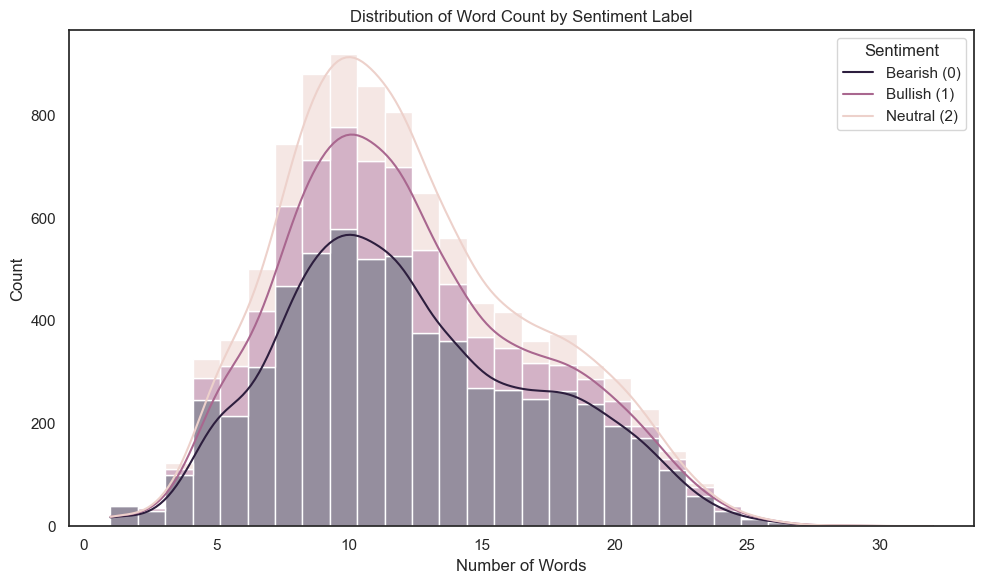

In [24]:
# Histogram of word count by label
plt.figure(figsize=(10, 6))
sns.histplot(data=df_train, x='word_count', hue='label', kde=True, bins=30, multiple='stack')
plt.title('Distribution of Word Count by Sentiment Label')
plt.xlabel('Number of Words')
plt.ylabel('Count')
plt.legend(title='Sentiment', labels=['Bearish (0)', 'Bullish (1)', 'Neutral (2)'])
plt.tight_layout()
plt.show()

All three distributions follow a roughly normal shape, suggesting that most tweets have a moderate word count, centered around 10–15 words. The overall count of the Neutral distribution appears higher, suggesting that the Neutral class might be more frequent in the dataset.

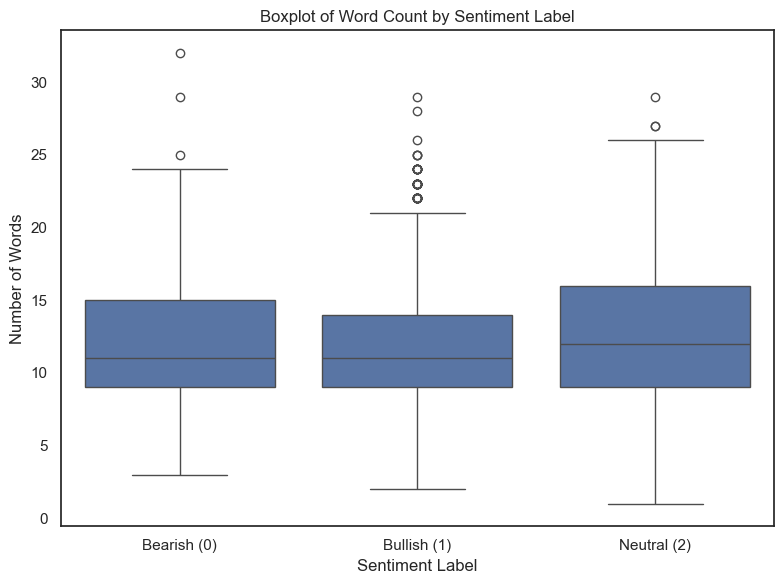

In [25]:
# Boxplot of word count by label
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_train, x='label', y='word_count')
plt.title('Boxplot of Word Count by Sentiment Label')
plt.xlabel('Sentiment Label')
plt.ylabel('Number of Words')
plt.xticks(ticks=[0, 1, 2], labels=['Bearish (0)', 'Bullish (1)', 'Neutral (2)'])
plt.tight_layout()
plt.show()

In [26]:
# Get most frequent words
def get_top_n_words(texts, n=20):
    all_words = ' '.join(texts).split()
    most_common = Counter(all_words).most_common(n)
    return dict(most_common)

In [27]:
# Plot word cloud for a specific label
def plot_top_words_bar(df, label, label_name):
    texts = df[df['label'] == label]['text']
    top_words = get_top_n_words(texts)
    
    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(top_words.values()), y=list(top_words.keys()))
    plt.title(f'Top Words for {label_name} Tweets')
    plt.xlabel('Frequency')
    plt.ylabel('Word')
    plt.tight_layout()
    plt.show()

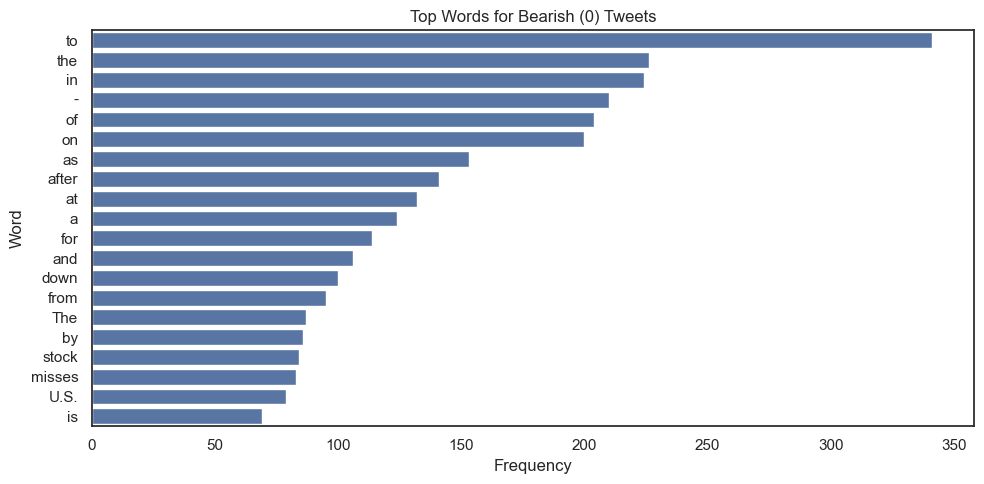

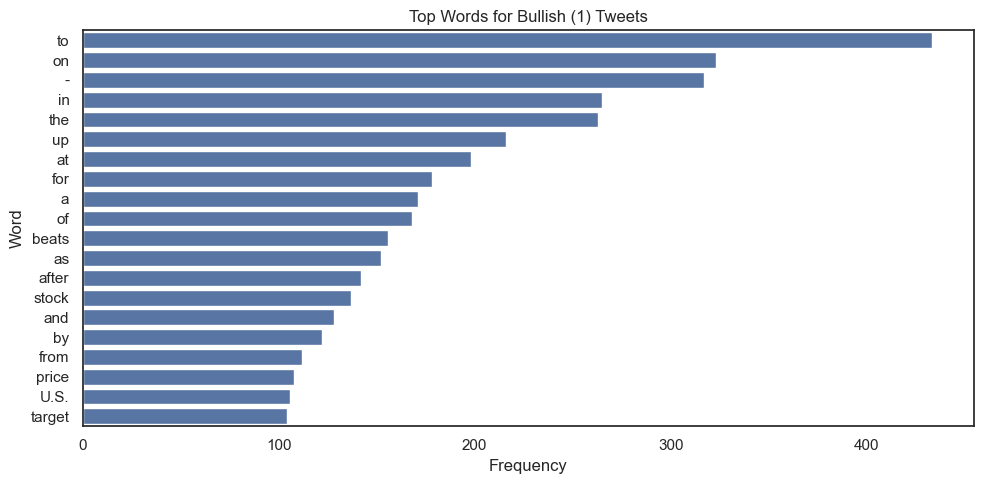

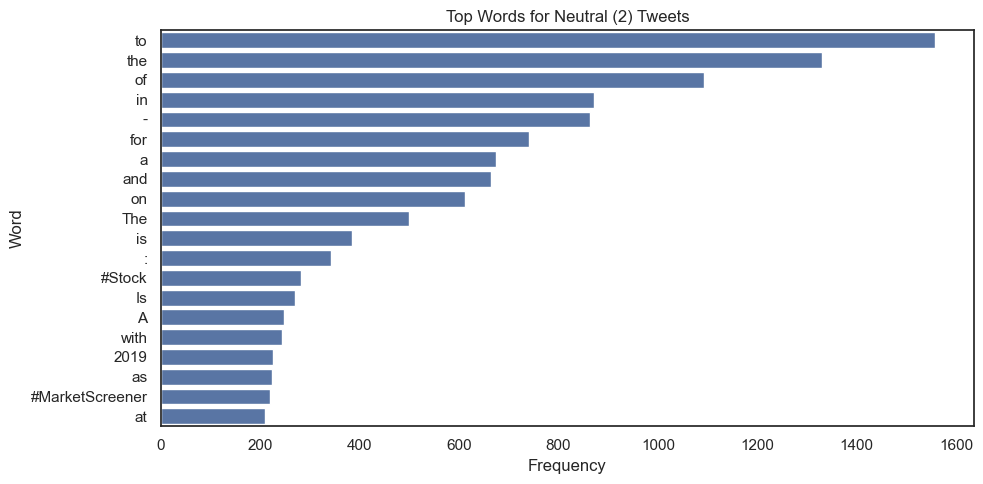

In [28]:
plot_top_words_bar(df_train, 0, 'Bearish (0)')
plot_top_words_bar(df_train, 1, 'Bullish (1)')
plot_top_words_bar(df_train, 2, 'Neutral (2)')

In [29]:
# Plot word cloud for each label
def plot_wordcloud(df, label, label_name):
    texts = df[df['label'] == label]['text']
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(texts))
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {label_name} Tweets', fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

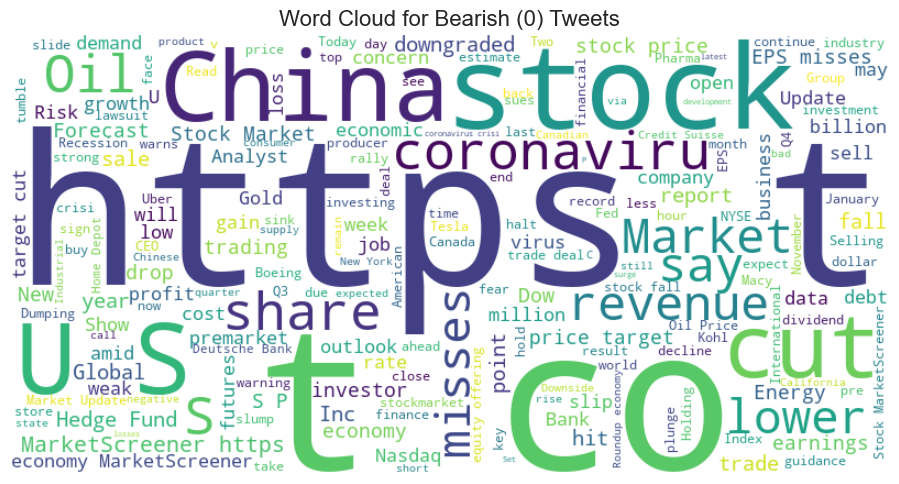

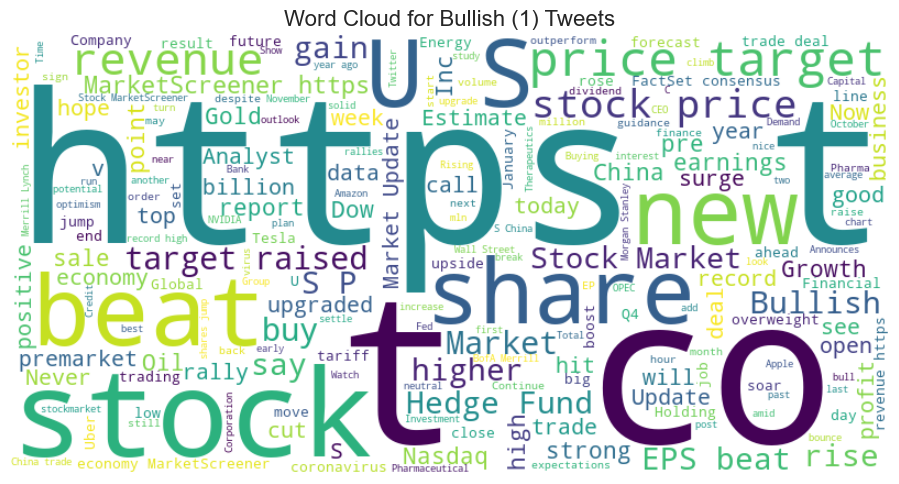

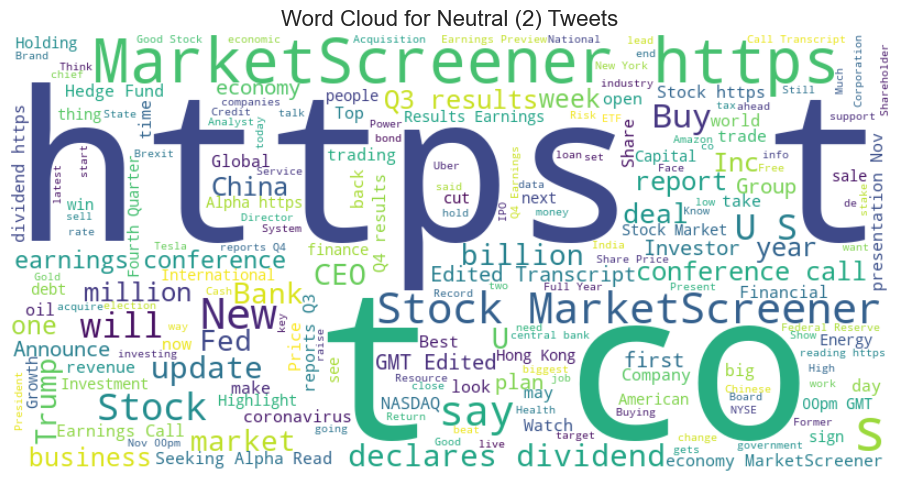

In [30]:
plot_wordcloud(df_train, 0, 'Bearish (0)')
plot_wordcloud(df_train, 1, 'Bullish (1)')
plot_wordcloud(df_train, 2, 'Neutral (2)')

`What the Word Clouds Reveal:` <br>

- Bearish Tweets often contain negatively charged words such as **cut, misses, lower, decline, and crisis-related terms like coronavirus, oil, and China**. This suggests a focus on economic threats, losses, and negative forecasts.

- Bullish Tweets are characterized by positive performance indicators such as **beat, rise, gain, target raised, and higher**. Words like buy and soar indicate strong investor confidence.

- Neutral Tweets tend to include objective and informative language, e.g., **update, conference call, results, CEO, dividend, MarketScreener**. These tweets appear more factual and less emotionally driven.


> The repeated appearance of noise tokens like **https, co, and rt** in all classes confirms the need for text cleaning before model training.

<a class="anchor" id="sub-section-2_3_2"></a>

### 2.3.2. Character Count & Labels

</a>

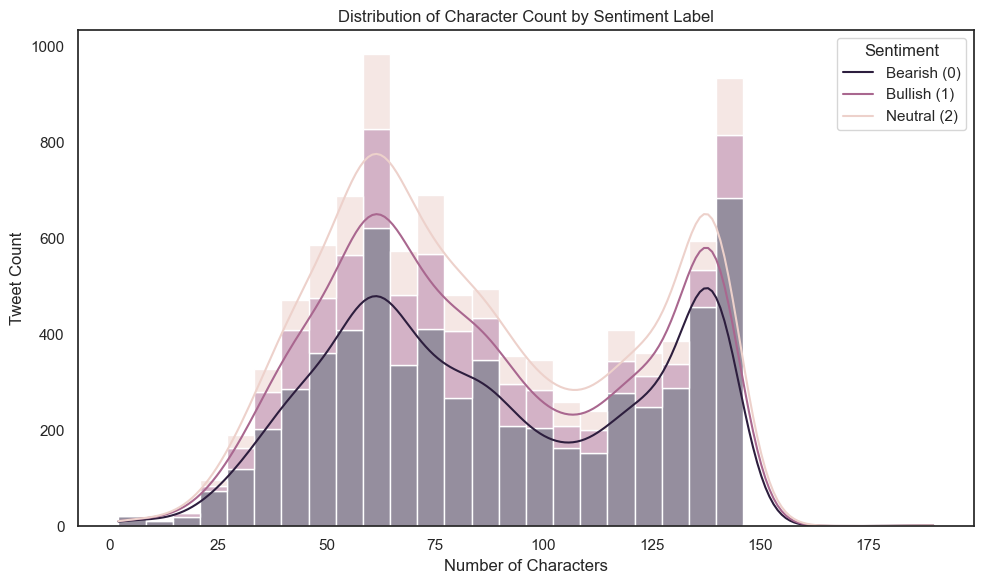

In [31]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df_train, x='char_count', hue='label', kde=True, bins=30, multiple='stack')
plt.title('Distribution of Character Count by Sentiment Label')
plt.xlabel('Number of Characters')
plt.ylabel('Tweet Count')
plt.legend(title='Sentiment', labels=['Bearish (0)', 'Bullish (1)', 'Neutral (2)'])
plt.tight_layout()
plt.show()

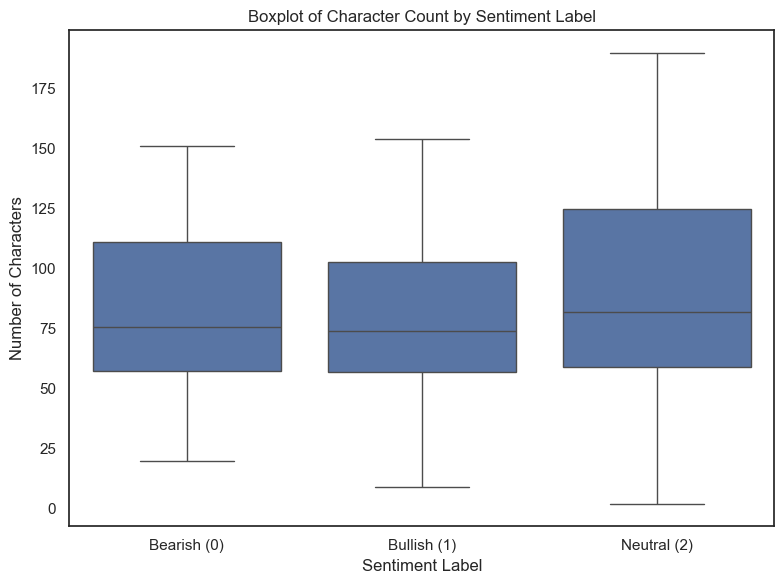

In [32]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_train, x='label', y='char_count')
plt.title('Boxplot of Character Count by Sentiment Label')
plt.xlabel('Sentiment Label')
plt.ylabel('Number of Characters')
plt.xticks(ticks=[0, 1, 2], labels=['Bearish (0)', 'Bullish (1)', 'Neutral (2)'])
plt.tight_layout()
plt.show()

<a class="anchor" id="sub-section-2_3_1"></a>

### 2.3.1. N-grams & Labels

</a>

By extracting the most frequent bigrams (2-word sequences) in the dataset, we identify recurring phrase patterns that reflect both the contextual structure of financial tweets and potential informative features for classification.

**A large portion of frequent bigrams are news-source references**, such as:

marketscreener https; <br>
stock marketscreener;<br>
economy marketscreener;<br>
stock https.

These likely come from automatic link-sharing tweets or syndicated content.

**Other bigrams are domain-specific and sentiment-relevant**, such as:

hedge funds;<br>
price target;<br>
stock market;<br>
stock price<br>
q3 results;<br>
earnings conference;

which are informative but likely neutral in tone.

In [33]:
vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english')
X = vectorizer.fit_transform(df_train['text'])
sum_words = X.sum(axis=0)

# Most common bigrams
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)[:10]

for word, freq in words_freq:
    print(f"{word}: {freq}")

marketscreener https: 478
stock marketscreener: 315
hedge funds: 163
price target: 141
stock market: 137
economy marketscreener: 137
stock price: 109
q3 results: 99
earnings conference: 90
stock https: 89


In [34]:
# Function to get top n-grams from the corpus
def get_top_ngrams(corpus, ngram_range=(2,2), n=20):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english')
    X = vec.fit_transform(corpus)
    sum_words = X.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    sorted_words = sorted(words_freq, key=lambda x: x[1], reverse=True)[:n]
    return pd.DataFrame(sorted_words, columns=['ngram', 'count'])

In [35]:
# Function to plot top n-grams
def plot_top_ngrams(df, label, label_name, ngram_range=(2,2), top_n=20):
    texts = df[df['label'] == label]['text'].str.lower()
    top_ngrams = get_top_ngrams(texts, ngram_range=ngram_range, n=top_n)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='count', y='ngram', data=top_ngrams)
    title_type = 'Bigrams' if ngram_range == (2,2) else 'Trigrams'
    plt.title(f'Top {title_type} in {label_name} Tweets')
    plt.xlabel('Frequency')
    plt.ylabel(title_type)
    plt.tight_layout()
    plt.show()

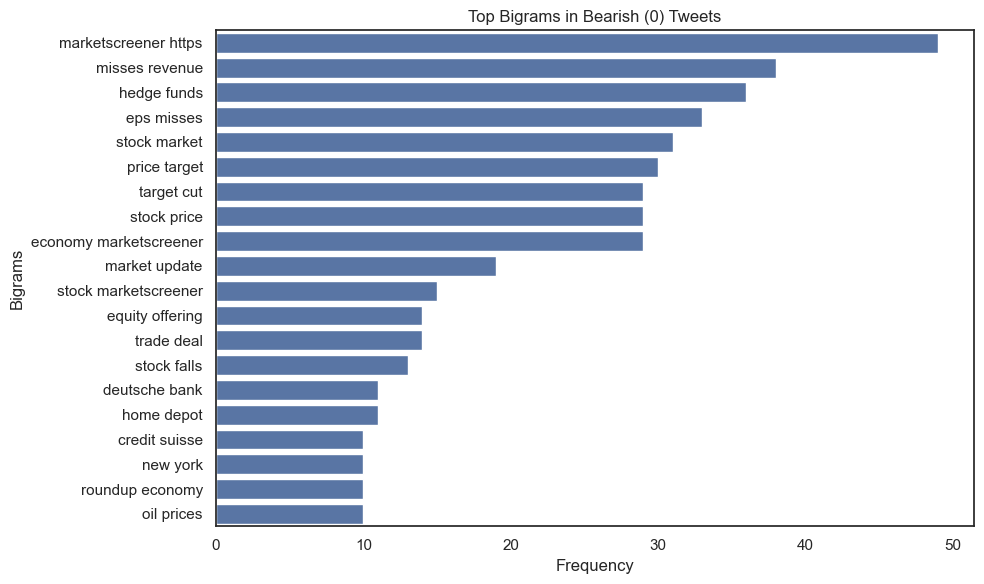

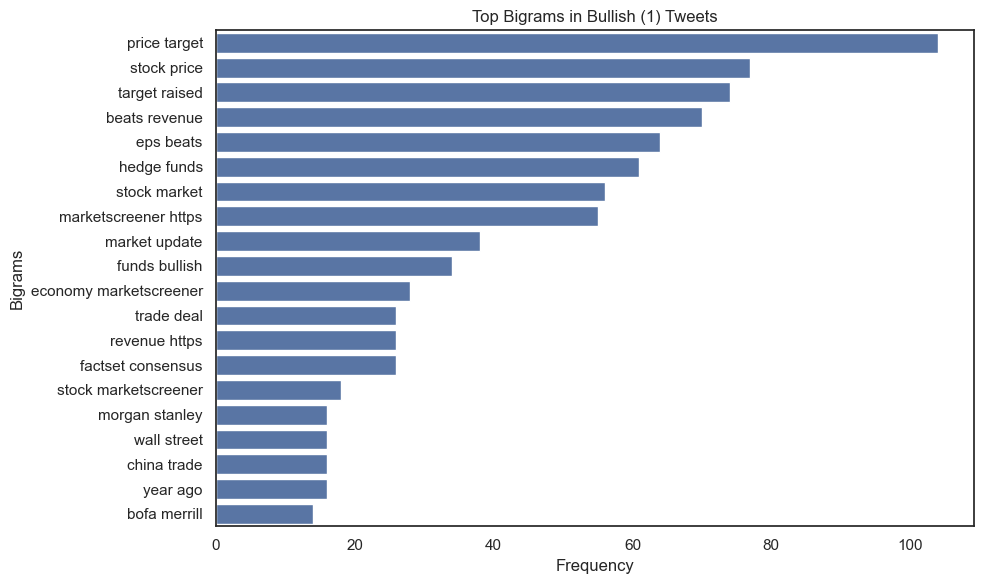

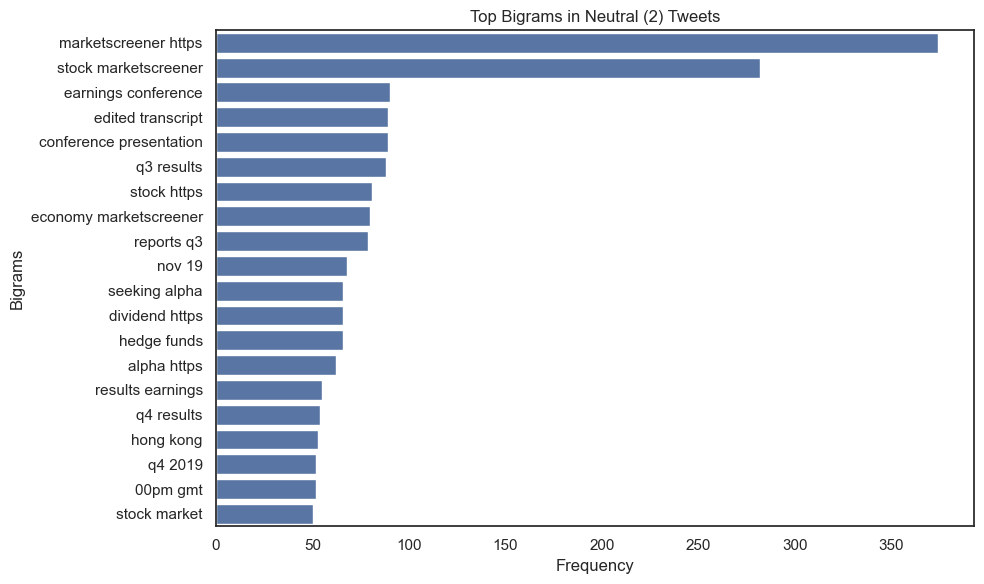

In [36]:
# Bigrams
plot_top_ngrams(df_train, 0, 'Bearish (0)', ngram_range=(2,2))
plot_top_ngrams(df_train, 1, 'Bullish (1)', ngram_range=(2,2))
plot_top_ngrams(df_train, 2, 'Neutral (2)', ngram_range=(2,2))

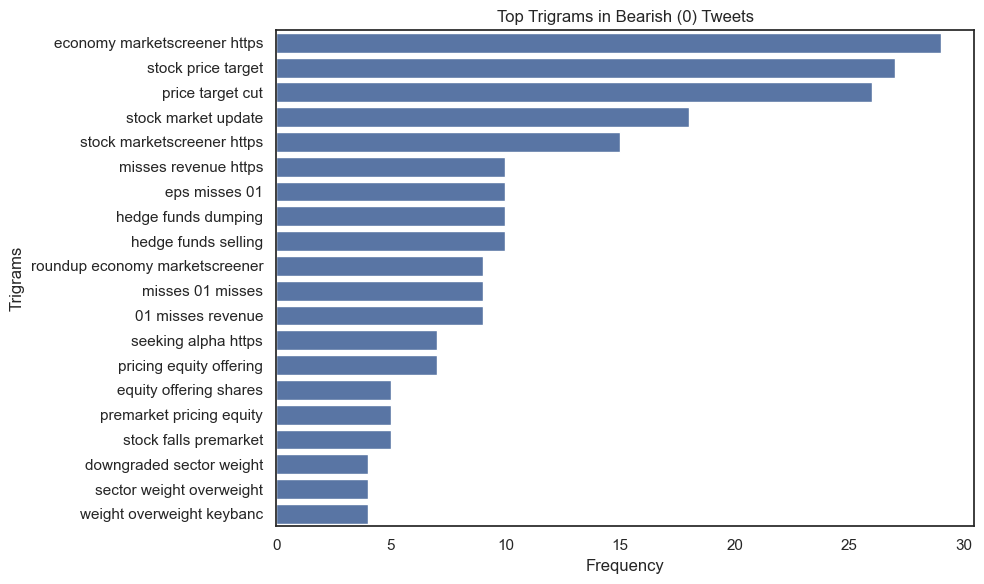

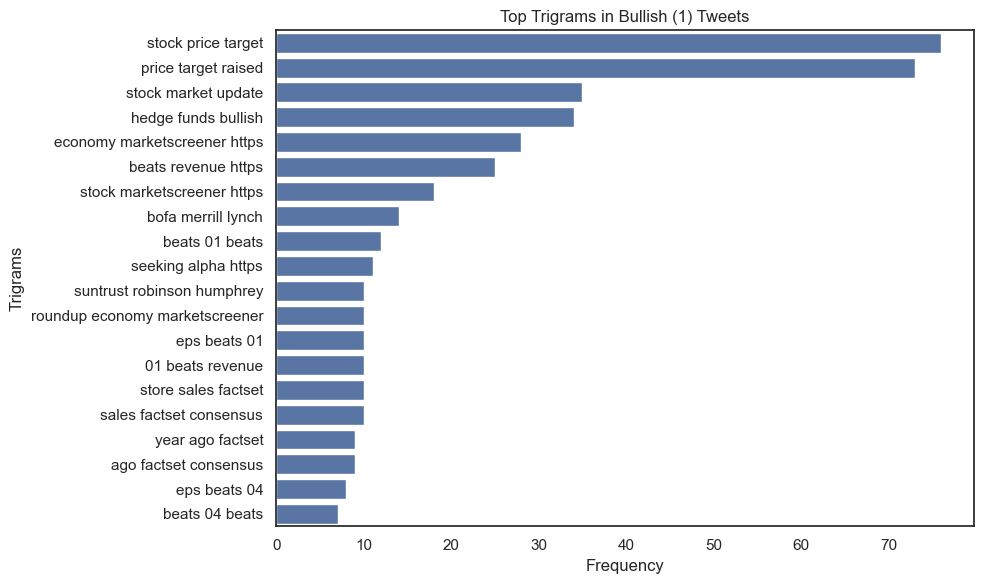

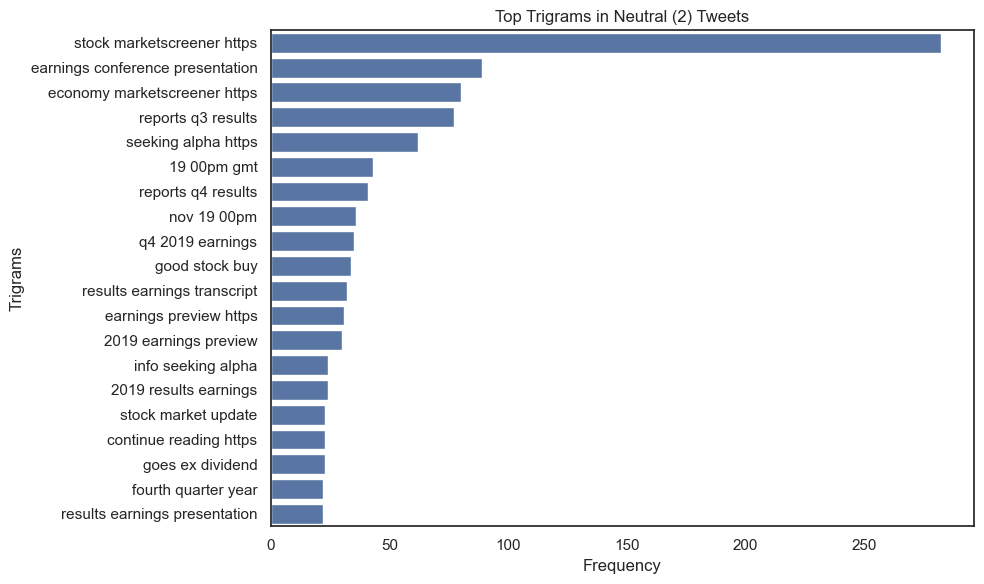

In [37]:
# Trigrams
plot_top_ngrams(df_train, 0, 'Bearish (0)', ngram_range=(3,3))
plot_top_ngrams(df_train, 1, 'Bullish (1)', ngram_range=(3,3))
plot_top_ngrams(df_train, 2, 'Neutral (2)', ngram_range=(3,3))

<a class="anchor" id="chapter3"></a>

# 3. Data Split

</a>

To prepare the dataset for model training and validation, we performed an 80/20 split on the labeled data. This means that **80% of the tweets were used for training, while 20% were held out for validation purposes**. <br>
**The split was done using stratified sampling** to ensure that the distribution of sentiment labels (Bearish, Bullish, and Neutral) remained consistent across both sets. This is **important for preventing class imbalance issues** during training and evaluation. <br>
We did not create a separate test set since a dedicated, unlabeled test dataset was already provided as part of the project. 

In [38]:
train_df, val_df = train_test_split(df_train, test_size=0.2, stratify=df_train['label'], random_state=42)

# Check class distribution
print("Training Set:\n", train_df['label'].value_counts(normalize=True))
print("\nValidation Set:\n", val_df['label'].value_counts(normalize=True))

Training Set:
 label
2    0.647367
1    0.201467
0    0.151166
Name: proportion, dtype: float64

Validation Set:
 label
2    0.647459
1    0.201676
0    0.150864
Name: proportion, dtype: float64


In [39]:
len(train_df), len(val_df)

(7634, 1909)

In [40]:
df_test.columns

Index(['text'], dtype='object')

<a class="anchor" id="chapter4"></a>

# 4. Data Preprocessing

</a>

To prepare the tweets for modeling, we applied a series of text preprocessing steps aligned with the theoretical guidelines from the course. The goal was to clean and normalize the text while retaining meaningful linguistic content for feature extraction.

The following techniques were applied:

`Lowercasing`  All text was converted to lowercase to ensure uniformity (e.g., “Stock” and “stock” are treated the same).

`Noise Removal` We removed URLs, mentions, hashtags, and retweet markers (RT) using regular expressions, as these tokens do not contribute to sentiment analysis.

`Punctuation and Digit Removal` All punctuation symbols and numeric characters were stripped to reduce sparsity and dimensionality.

`Tokenization` We used NLTK’s TreebankWordTokenizer, a rule-based tokenizer that works efficiently without external dependencies like punkt.

`Stopword Removal and Lemmatization` We filtered out common English stopwords (e.g., "and", "the", "of") and lemmatized each remaining token to reduce inflectional variations (e.g., “running” → “run”).

These steps produced a clean and compact representation of the original tweets, ready for downstream tasks like vectorization and sentiment classification.

In [41]:
# Download required resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ruben\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ruben\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ruben\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ruben\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [42]:
# Initialize tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
tokenizer = TreebankWordTokenizer()

In [43]:
# Preprocessing function
def preprocess_text(text):
    # 1. Lowercase
    text = text.lower()
    
    # 2. Regex Cleaning
    text = re.sub(r"http\S+|www\S+", '', text)                         # Remove URLs
    text = re.sub(r"@\w+|#\w+|rt", '', text)                           # Remove mentions, hashtags, RT
    text = re.sub(r"br", "", text)                                     # Remove 'br' (e.g. <br> tags)
    text = re.sub(f"[{re.escape(string.punctuation)}]", '', text)      # Remove punctuation
    text = re.sub(r"[^a-zA-Z\s]", ' ', text)                           # Remove numbers and special characters
    text = re.sub(r"\s+", " ", text).strip()                           # Remove extra whitespace

    # 3. Tokenize using Treebank tokenizer
    tokens = tokenizer.tokenize(text)

    # 4. Remove stopwords and short tokens, then lemmatize
    clean_tokens = [
        lemmatizer.lemmatize(token)
        for token in tokens
        if token not in stop_words and len(token) > 2
    ]

    return " ".join(clean_tokens)

In [44]:
# Apply function to train and validation datasets
train_df['clean_text'] = train_df['text'].fillna('').apply(preprocess_text)
val_df['clean_text']   = val_df['text'].fillna('').apply(preprocess_text)
df_test['clean_text']  = df_test['text'].fillna('').apply(preprocess_text)


In [45]:
# Check before and after cleaning
print("Original tweet:\n", train_df['text'].iloc[6])
print("Cleaned tweet:\n", train_df['clean_text'].iloc[6])

Original tweet:
 Could Applied DNA Sciences, Inc. (APDN) See a Reversal After Breaking Its 52 Week Low? - The Lamp News
Cleaned tweet:
 could applied dna science inc apdn see reversal eaking week low lamp news


<a class="anchor" id="chapter5"></a>

# 5. Feature Engineering

</a>

In [46]:
X_train_cleaned = train_df['clean_text']
X_val_cleaned = val_df['clean_text']
X_test_cleaned = df_test['clean_text']

In [47]:
df_test.columns

Index(['text', 'clean_text'], dtype='object')

In [48]:
# Prepare data and get y (labels)
y_train = train_df['label']
y_val = val_df['label']

<a class="anchor" id="sub-section-5_1"></a>

## 5.1. BoW

</a>

In [49]:
def extract_bow_features(train_texts, val_texts):
    vectorizer = CountVectorizer(binary=True)
    X_train = vectorizer.fit_transform(train_texts)
    X_val = vectorizer.transform(val_texts)
    return X_train, X_val, vectorizer

In [50]:
# Apply BoW to training and validation sets
bow_X_train, bow_X_val, bow_vectorizer = extract_bow_features(X_train_cleaned, X_val_cleaned)

In [51]:
term_counts = np.array(bow_X_train.sum(axis=0)).flatten()
terms = bow_vectorizer.get_feature_names_out()
top_terms_df = pd.DataFrame({'term': terms, 'count': term_counts}).sort_values(by='count', ascending=False)

In [52]:
top_terms_df.head(10)

,term,count
10325,stock,656
6507,market,346
8481,price,315
7244,new,310
9484,say,307
9123,result,304
9735,share,273
3326,earnings,273
5294,inc,246
4345,fund,239


<a class="anchor" id="sub-section-5_2"></a>

## 5.2. TF-IDF

</a>

In [53]:
def extract_tfidf_features(train_texts, val_texts):
    vectorizer = TfidfVectorizer(max_df=0.8, ngram_range=(1,1))
    X_train = vectorizer.fit_transform(train_texts).toarray()
    X_val = vectorizer.transform(val_texts).toarray()
    return X_train, X_val, vectorizer

In [54]:
tfidf_X_train, tfidf_X_val, tfidf_vectorizer = extract_tfidf_features(X_train_cleaned, X_val_cleaned)   # the test is missing here

In [55]:
# View top 10 IDF values
idf_dict = dict(zip(tfidf_vectorizer.get_feature_names_out(), tfidf_vectorizer.idf_))
list(idf_dict.items())[4100:4110]

[('firstquaer', 9.247351037092788),
 ('firsttime', 8.554203856532842),
 ('fiscal', 6.721622392784532),
 ('fisher', 9.247351037092788),
 ('fit', 8.841885928984624),
 ('fitbit', 9.247351037092788),
 ('fitful', 9.247351037092788),
 ('fitness', 8.331060305218632),
 ('fittest', 9.247351037092788),
 ('fitzgerald', 9.247351037092788)]

In [56]:
# Embedding for the lstm model


<a class="anchor" id="sub-section-5_3"></a>

## 5.3. Word2Vec

</a>

In [57]:
def get_average_word2vec(texts, model):
    features = []
    for text in texts:
        words = text.split()
        valid_words = [model.wv[word] for word in words if word in model.wv]
        if valid_words:
            avg = np.mean(valid_words, axis=0)
        else:
            avg = np.zeros(model.vector_size)
        features.append(avg)
    return np.array(features)

In [58]:
tokenized_train = [text.split() for text in X_train_cleaned]
tokenized_val = [text.split() for text in X_val_cleaned]

In [59]:
w2v_model = Word2Vec(sentences=tokenized_train, vector_size=100, window=5, min_count=1)

In [60]:
word2vec_X_train = get_average_word2vec(X_train_cleaned, w2v_model)
word2vec_X_val = get_average_word2vec(X_val_cleaned, w2v_model)
word2vec_X_test = get_average_word2vec(X_test_cleaned, w2v_model)


The first step to train the LSTM with Word2Vec is to adapt the original approach. Initially, we averaged the Word2Vec vectors for each sentence, which removed word order and produced fixed-size feature vectors. While this is fine for traditional ML models, it’s not suitable for LSTMs, which require sequential input.


To make Word2Vec compatible with LSTM, we:

- Tokenize the text into sequences of word indices using Tokenizer

- Pad the sequences to a fixed length to ensure uniform input shape

- Build an Embedding layer using the pre-trained Word2Vec vectors (embedding matrix)

- Feed the padded sequences into the Embedding + LSTM layers

This adaptation preserves the order of words and allows the LSTM to learn from the sequential structure of the text


In [61]:

# Tokenizing the cleaned training text into sequences of word indices
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_cleaned)

# Converting training and test texts into sequences of word indices
X_train_seq = tokenizer.texts_to_sequences(X_train_cleaned)
X_val_seq = tokenizer.texts_to_sequences(X_val_cleaned)
X_test_seq = tokenizer.texts_to_sequences(X_test_cleaned)


# Pad sequences to ensure all have the same length
MAXLEN = 100  # Max number of tokens per sentence
X_train_pad = pad_sequences(X_train_seq, maxlen=MAXLEN, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=MAXLEN, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAXLEN, padding='post')

import numpy as np

# Creating the embedding matrix using the pre-trained Word2Vec model
word_index = tokenizer.word_index  # Dictionary mapping words to their index
vocab_size = len(word_index) + 1  # +1 for padding token
embedding_dim = w2v_model.vector_size  # Dimension of Word2Vec embeddings


# Initialize the embedding matrix with zeros
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, idx in word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[idx] = w2v_model.wv[word]


# Filling embedding matrix, each row i corresponds to the Word2Vec vector of the word with index i
for word, idx in word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[idx] = w2v_model.wv[word]   # Assign vector if word exists in Word2Vec vocab

<a class="anchor" id="sub-section-5_4"></a>

## 5.4. Distil BERT

</a>

Here, **we used BERT-based sentence embeddings via the DistilBERT model from Hugging Face**. Unlike traditional methods like TF-IDF, **BERT captures contextual relationships between words, which is particularly useful for short, informal text like tweets**. <br>
We applied DistilBERT’s tokenizer to each tweet, padded and truncated the sequences to a fixed length, and passed them through the pretrained encoder. From the output, we extracted the embedding of the [CLS] token, which serves as a summary representation of the entire tweet. This process produced a 768-dimensional vector for each tweet in both the training and validation sets. <br>
These dense embeddings will be used as input features for our classifier, allowing it to leverage semantic information and improve sentiment prediction performance.

In [62]:
# Load pretrained DistilBERT model and tokenizer
bert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
bert_model = DistilBertModel.from_pretrained('distilbert-base-uncased')

In [63]:
# Disable dropout
bert_model.eval()

# CLS embeddings for classification tasks
def transformer_cls_embeddings(texts, batch_size=32):
    all_embs = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i : i + batch_size]
        enc = bert_tokenizer(
            batch,
            padding=True,
            truncation=True,
            return_tensors="pt"
        )
        with torch.no_grad():
            out = bert_model(**enc)
        # out.last_hidden_state: (batch, seq_len, hidden_dim)
        cls_embs = out.last_hidden_state[:, 0, :]  # First token is [CLS]
        all_embs.append(cls_embs.cpu().numpy())
    return np.vstack(all_embs)

# Embed the training and test sets
X_train_transformer = transformer_cls_embeddings(X_train_cleaned.tolist())
X_val_transformer  = transformer_cls_embeddings(X_val_cleaned.tolist())
X_test_transformer = transformer_cls_embeddings(X_test_cleaned.tolist())

Transformer Token-Level Embeddings for LSTM

Here, we use a pretrained DistilBERT model to generate token-level embeddings for each text:

1. Each sentence is tokenized and padded to a fixed length.
2. The model outputs a sequence of hidden states (one per token).
3. These token embeddings are extracted and stored as input features.

This creates a 3D tensor (samples × max_length × 768), suitable for feeding into an LSTM that learns from contextualized token representations.


In [64]:
def transformer_token_embeddings(texts, batch_size=16, max_length=32):
    all_seqs = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        enc = bert_tokenizer(
            batch,
            padding="max_length",
            truncation=True,
            max_length=max_length,
            return_tensors="pt"
        )
        with torch.no_grad():
            out = bert_model(**enc)
        last_hidden = out.last_hidden_state  # shape: (batch, max_length, 768)
        all_seqs.append(last_hidden.cpu().numpy())
    return np.concatenate(all_seqs, axis=0)

# Embed the training and test sets
X_train_bert_seq = transformer_token_embeddings(X_train_cleaned.tolist())
X_test_bert_seq  = transformer_token_embeddings(X_test_cleaned.tolist())
X_val_bert_seq = transformer_token_embeddings(X_val_cleaned.tolist())

**Dataset Classes for Transformer Models<br>**

To efficiently feed our cleaned text into transformer-based models, we use two PyTorch dataset classes: FinDataset (for training/validation) and InferenceDataset (for test-time inference).<br>
Both rely on the same tokenizer settings to ensure consistency.

How it works:

- Each cleaned text is tokenized with a pretrained tokenizer, padded or truncated to a fixed maximum length (64 tokens).

- The output (input IDs, attention masks, etc.) is stored as PyTorch tensors for each sample.

- The corresponding label is included as a tensor for supervised learning.

This class is directly compatible with Hugging Face’s Trainer or custom PyTorch training loops.


In [65]:
class FinDataset(Dataset):
    def __init__(self, texts, labels):
        self.encodings = bert_tokenizer(
            texts.tolist(),
            truncation=True,
            padding=True,
            max_length=64
        )
        self.labels = labels.tolist()

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


class InferenceDataset(Dataset): # for the test dataset
    def __init__(self, texts):
        self.encodings = bert_tokenizer(
            texts.tolist(),
            truncation=True,
            padding=True,
            max_length=64
        )

    def __getitem__(self, idx):
        return {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}

    def __len__(self):
        return len(self.encodings['input_ids'])

train_dataset = FinDataset(X_train_cleaned, y_train)
val_dataset   = FinDataset(X_val_cleaned, y_val)
test_dataset = InferenceDataset(X_test_cleaned)

Dataset Preparation for Transformer Fine-Tuning

We define a custom PyTorch `Dataset` to wrap the text and labels:

1. Texts are tokenized using the DistilBERT tokenizer with padding and truncation.
2. Labels are converted to tensors for supervised training.
3. The dataset returns tokenized inputs and corresponding labels for each sample.

This format is required for fine-tuning the DistilBERT model using Hugging Face’s `Trainer` API.


<a class="anchor" id="sub-section-5_6"></a>

## 5.6. Sentence-Transformer (SBERT) for Financial Sentences

</a>

Sentence-Transformer (SBERT) for Financial Sentences

https://huggingface.co/ohsuz/k-finance-sentence-transformer

In [66]:
# Load the finance-tuned SBERT
sbert = SentenceTransformer("ohsuz/k-finance-sentence-transformer")

# Encode
sbert_X_train = sbert.encode(X_train_cleaned.tolist(), show_progress_bar=True)
sbert_X_val  = sbert.encode(X_val_cleaned.tolist(),  show_progress_bar=True)
sbert_X_test = sbert.encode(X_test_cleaned.tolist(), show_progress_bar=True)

Batches: 100%|██████████| 75/75 [00:26<00:00,  2.86it/s]


<a class="anchor" id="chapter6"></a>

# 6. Models

</a>

<a class="anchor" id="sub-section-6_1"></a>

## 6.1. Functions for Evaluation

</a>

In [67]:
# For individual evaluation
def evaluate_classification(feature_used, y_true, y_pred):
    print("Evaluation metrics with", feature_used, "features.")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision (macro):", precision_score(y_true, y_pred, average='macro'))
    print("Recall (macro):", recall_score(y_true, y_pred, average='macro'))
    print("F1 Score (macro):", f1_score(y_true, y_pred, average='macro'))
    print("\nDetailed Classification Report:\n")
    print(classification_report(y_true, y_pred, digits=4))

In [68]:
# For comparing results across models and representations

# Starting with the table structure
results_columns = [
    "Model", "Representation",
    # Train Metrics 
    "Train_Prec", "Train_Rec", "Train_F1",
    # Val Metrics
    "Val_Prec",   "Val_Rec",   "Val_F1",
]
results = pd.DataFrame(columns=results_columns)

# log_result unpacks both overall and per-label metrics
def log_result(
    # Defining the class of each each parameter    
    model_name: str,
    feat_name: str,
    # overall
    train_prec: float, train_rec: float, train_f1: float,
    # validation overall
    val_prec: float,   val_rec: float,   val_f1: float,
):
    global results
    row = {
        "Model": model_name,
        "Representation": feat_name,
        # Overall Train
        "Train_Prec": train_prec,
        "Train_Rec":  train_rec,
        "Train_F1":   train_f1,
        # Overall Val 
        "Val_Prec":   val_prec,
        "Val_Rec":    val_rec,
        "Val_F1":     val_f1
    }
    results.loc[len(results)] = row


def evaluate_and_log(
    model_name, feat_name, model, X_tr, y_tr, X_te, y_te
):
    # Predictions
    y_tr_pred = model.predict(X_tr)
    y_te_pred = model.predict(X_te)

    # If output is probabilities (LSTM, softmax, etc), convert to class labels
    if len(y_tr_pred.shape) > 1 and y_tr_pred.shape[1] > 1:
        y_tr_pred = y_tr_pred.argmax(axis=1)
        y_te_pred = y_te_pred.argmax(axis=1)

    # Train Metrics 
    tr_prec = precision_score(y_tr, y_tr_pred, average="macro")
    tr_rec  = recall_score(   y_tr, y_tr_pred, average="macro")
    tr_f1   = f1_score(       y_tr, y_tr_pred, average="macro")

    # Val Metrics 
    val_prec = precision_score(y_te, y_te_pred, average="macro")
    val_rec  = recall_score(   y_te, y_te_pred, average="macro")
    val_f1   = f1_score(       y_te, y_te_pred, average="macro")
    
    # Log Everything into the results table 
    log_result(
        model_name=model_name,
        feat_name=feat_name,
        train_prec=tr_prec,
        train_rec=tr_rec,
        train_f1=tr_f1,
        val_prec=val_prec,
        val_rec=val_rec,
        val_f1=val_f1
    )

# show() to display the results table
def show():
    print(results.to_string(index=False))

<a class="anchor" id="sub-section-6_2"></a>

## 6.2. KNN

</a>

In [69]:
knn = KNeighborsClassifier(n_neighbors=5)

<a class="anchor" id="sub-section-6_2_1"></a>

### 6.2.1. WITH BOW

</a>

In [70]:

knn.fit(bow_X_train, y_train)
knn_bow_pred = knn.predict(bow_X_val)

In [71]:
evaluate_classification("BoW", y_val, knn_bow_pred)

Evaluation metrics with BoW features.
Accuracy: 0.7008905185961236
Precision (macro): 0.6831263076597635
Recall (macro): 0.45235912056300404
F1 Score (macro): 0.46991597110124744

Detailed Classification Report:

              precision    recall  f1-score   support

           0     0.6197    0.1528    0.2451       288
           1     0.7273    0.2286    0.3478       385
           2     0.7024    0.9757    0.8168      1236

    accuracy                         0.7009      1909
   macro avg     0.6831    0.4524    0.4699      1909
weighted avg     0.6949    0.7009    0.6360      1909



In [72]:
evaluate_and_log(
    model_name="KNN",
    feat_name="BoW",
    model=knn,
    X_tr=bow_X_train,
    y_tr=y_train,
    X_te=bow_X_val,
    y_te=y_val
)

<a class="anchor" id="sub-section-6_2_2"></a>

### 6.2.2. WITH TF-IDF

</a>

In [73]:
knn.fit(tfidf_X_train, y_train)
knn_tfidf_pred = knn.predict(tfidf_X_val)

c:\Users\ruben\.conda\envs\DeepLearning2425\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\ruben\.conda\envs\DeepLearning2425\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\ruben\.conda\envs\DeepLearning2425\Lib\subprocess.py", line 550, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ruben\.conda\envs\DeepLearning2425\Lib\subprocess.py", line 1028, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\ruben\.conda\envs\DeepLearnin

In [74]:
evaluate_classification("TF-IDF", y_val, knn_tfidf_pred)

Evaluation metrics with TF-IDF features.
Accuracy: 0.679413305395495
Precision (macro): 0.6806979859571323
Recall (macro): 0.4009081219032675
F1 Score (macro): 0.39125538280616007

Detailed Classification Report:

              precision    recall  f1-score   support

           0     0.5366    0.0764    0.1337       288
           1     0.8281    0.1377    0.2361       385
           2     0.6774    0.9887    0.8039      1236

    accuracy                         0.6794      1909
   macro avg     0.6807    0.4009    0.3913      1909
weighted avg     0.6865    0.6794    0.5883      1909



In [75]:
evaluate_and_log(
    model_name="KNN",
    feat_name="TF-IDF",
    model=knn,
    X_tr=tfidf_X_train,
    y_tr=y_train,
    X_te=tfidf_X_val,
    y_te=y_val
)

<a class="anchor" id="sub-section-6_2_3"></a>

### 6.2.3. WITH WORD2VEC

</a>

In [76]:
knn.fit(word2vec_X_train, y_train)
knn_word2vec_pred = knn.predict(word2vec_X_val)

In [77]:
evaluate_classification("Word2Vec", y_val, knn_word2vec_pred)

Evaluation metrics with Word2Vec features.
Accuracy: 0.5997904662126768
Precision (macro): 0.429215659985915
Recall (macro): 0.4158084544006874
F1 Score (macro): 0.4192972750764719

Detailed Classification Report:

              precision    recall  f1-score   support

           0     0.1888    0.1528    0.1689       288
           1     0.3826    0.2961    0.3338       385
           2     0.7163    0.7985    0.7552      1236

    accuracy                         0.5998      1909
   macro avg     0.4292    0.4158    0.4193      1909
weighted avg     0.5694    0.5998    0.5817      1909



In [78]:
evaluate_and_log(
    model_name="KNN",
    feat_name="Word2Vec",
    model=knn,
    X_tr=word2vec_X_train,
    y_tr=y_train,
    X_te=word2vec_X_val,
    y_te=y_val
)

<a class="anchor" id="sub-section-6_2_4"></a>

### 6.2.4. WITH DISTIL BERT

</a>

In [79]:
knn.fit(X_train_transformer, y_train)
knn_dbert_pred = knn.predict(X_val_transformer)

In [80]:
evaluate_classification("Distil BERT",y_val, knn_dbert_pred)

Evaluation metrics with Distil BERT features.
Accuracy: 0.6752226296490309
Precision (macro): 0.5572147873401648
Recall (macro): 0.5615052513110766
F1 Score (macro): 0.5590606714936013

Detailed Classification Report:

              precision    recall  f1-score   support

           0     0.3972    0.3889    0.3930       288
           1     0.4604    0.4987    0.4788       385
           2     0.8140    0.7969    0.8054      1236

    accuracy                         0.6752      1909
   macro avg     0.5572    0.5615    0.5591      1909
weighted avg     0.6798    0.6752    0.6773      1909



<a class="anchor" id="sub-section-6_2_5"></a>

### 6.2.5. WITH SENTENCE BERT

</a>

In [81]:
knn.fit(sbert_X_train, y_train)
knn_sbert_pred = knn.predict(sbert_X_val)

In [82]:
evaluate_classification("Sentence-BERT", y_val, knn_sbert_pred)

Evaluation metrics with Sentence-BERT features.
Accuracy: 0.642744892613934
Precision (macro): 0.5217780545945366
Recall (macro): 0.5156653801071277
F1 Score (macro): 0.5185118258701196

Detailed Classification Report:

              precision    recall  f1-score   support

           0     0.3513    0.3403    0.3457       288
           1     0.4530    0.4260    0.4391       385
           2     0.7610    0.7807    0.7708      1236

    accuracy                         0.6427      1909
   macro avg     0.5218    0.5157    0.5185      1909
weighted avg     0.6371    0.6427    0.6397      1909



In [83]:
evaluate_and_log(
    model_name="KNN",
    feat_name="Sentence BERT",
    model=knn,
    X_tr=sbert_X_train,
    y_tr=y_train,
    X_te=sbert_X_val,
    y_te=y_val
)

### 6.2.6. Fine-tuning the best combination

In [84]:
# Feature and label
X = X_train_transformer
y = y_train

# Define parameter grid for tuning
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'cosine']
}

# Stratified K-Fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

knn_grid = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=param_grid,
    scoring='f1_macro',
    cv=cv,
    verbose=2,
    n_jobs=-1
)

In [85]:

# Training
knn_grid.fit(X, y)

# Best model, parameters and score
best_knn = knn_grid.best_estimator_
print("Best params:", knn_grid.best_params_)
print("Best CV F1 macro score:", knn_grid.best_score_)

# Predict on test
y_pred = best_knn.predict(X_val_transformer)


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best params: {'metric': 'cosine', 'n_neighbors': 5, 'weights': 'distance'}
Best CV F1 macro score: 0.5657814101181795


In [86]:
# Storing the results
evaluate_classification("Transformer BERT CV", y_val, y_pred)

evaluate_and_log(
    model_name="KNN CV-GS",
    feat_name="Transformer BERT",
    model=best_knn,
    X_tr=X_train_transformer,
    y_tr=y_train,
    X_te=X_val_transformer,
    y_te=y_val
)

Evaluation metrics with Transformer BERT CV features.
Accuracy: 0.6993190151911995
Precision (macro): 0.5862719684236994
Recall (macro): 0.5605821565166226
F1 Score (macro): 0.5697384197140822

Detailed Classification Report:

              precision    recall  f1-score   support

           0     0.4737    0.3438    0.3984       288
           1     0.4871    0.4909    0.4890       385
           2     0.7980    0.8471    0.8218      1236

    accuracy                         0.6993      1909
   macro avg     0.5863    0.5606    0.5697      1909
weighted avg     0.6864    0.6993    0.6908      1909



<a class="anchor" id="sub-section-6_2"></a>

## 6.3. Logistic Regression

</a>

In [87]:
clf = LogisticRegression(max_iter=1000, random_state=42)

<a class="anchor" id="sub-section-6_3_1"></a>

### 6.3.1. WITH BOW

</a>

In [88]:
clf.fit(bow_X_train, y_train)
clf_bow_pred = clf.predict(bow_X_val)

In [89]:
evaluate_classification("BoW", y_val, clf_bow_pred)

Evaluation metrics with BoW features.
Accuracy: 0.7888947092718701
Precision (macro): 0.7509790118387301
Recall (macro): 0.6520884994185965
F1 Score (macro): 0.6874656064651626

Detailed Classification Report:

              precision    recall  f1-score   support

           0     0.6911    0.4583    0.5511       288
           1     0.7526    0.5610    0.6429       385
           2     0.8092    0.9369    0.8684      1236

    accuracy                         0.7889      1909
   macro avg     0.7510    0.6521    0.6875      1909
weighted avg     0.7800    0.7889    0.7750      1909



In [90]:
evaluate_and_log(
    model_name="Logistic Regression",
    feat_name="BoW",
    model=clf,
    X_tr=bow_X_train,
    y_tr=y_train,
    X_te=bow_X_val,
    y_te=y_val
)

<a class="anchor" id="sub-section-6_3_2"></a>

### 6.3.2. WITH TF-IDF

</a>

In [91]:
clf.fit(tfidf_X_train, y_train)
clf_tfidf_pred = clf.predict(tfidf_X_val)

In [92]:
evaluate_classification("BoW", y_val, clf_tfidf_pred)

Evaluation metrics with BoW features.
Accuracy: 0.7684651650078576
Precision (macro): 0.7653564730463723
Recall (macro): 0.5941138149876014
F1 Score (macro): 0.638318134054717

Detailed Classification Report:

              precision    recall  f1-score   support

           0     0.7742    0.3333    0.4660       288
           1     0.7510    0.4935    0.5956       385
           2     0.7709    0.9555    0.8533      1236

    accuracy                         0.7685      1909
   macro avg     0.7654    0.5941    0.6383      1909
weighted avg     0.7674    0.7685    0.7429      1909



In [93]:
evaluate_and_log(
    model_name="Logistic Regression",
    feat_name="TF-IDF",
    model=clf,
    X_tr=tfidf_X_train,
    y_tr=y_train,
    X_te=tfidf_X_val,
    y_te=y_val
)

<a class="anchor" id="sub-section-6_3_3"></a>

### 6.3.3. WITH WORD2VEC

</a>

In [94]:
clf.fit(word2vec_X_train, y_train)
clf_word2vec_pred = clf.predict(word2vec_X_val)

In [95]:
evaluate_classification("BoW", y_val, clf_word2vec_pred)

Evaluation metrics with BoW features.
Accuracy: 0.6516500785751702
Precision (macro): 0.368930266520628
Recall (macro): 0.357547037644125
F1 Score (macro): 0.31549775671264896

Detailed Classification Report:

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       288
           1     0.4458    0.0961    0.1581       385
           2     0.6610    0.9765    0.7884      1236

    accuracy                         0.6517      1909
   macro avg     0.3689    0.3575    0.3155      1909
weighted avg     0.5179    0.6517    0.5423      1909



c:\Users\ruben\.conda\envs\DeepLearning2425\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ruben\.conda\envs\DeepLearning2425\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ruben\.conda\envs\DeepLearning2425\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

In [96]:
evaluate_and_log(
    model_name="Logistic Regression",
    feat_name="Word2Vec",
    model=clf,
    X_tr=word2vec_X_train,
    y_tr=y_train,
    X_te=word2vec_X_val,
    y_te=y_val
)

c:\Users\ruben\.conda\envs\DeepLearning2425\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ruben\.conda\envs\DeepLearning2425\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<a class="anchor" id="sub-section-6_3_4"></a>

### 6.3.4. WITH DISTIL BERT

</a>

In [97]:
clf.fit(X_train_transformer, y_train)
clf_dbert_pred = clf.predict(X_val_transformer)

In [98]:
print("Validation Set Results:\n")
print(classification_report(y_val, clf_dbert_pred, target_names=["Bearish", "Bullish", "Neutral"]))

evaluate_and_log(
    model_name="Logistic Regression",
    feat_name="Distil BERT",
    model=clf,
    X_tr=X_train_transformer,
    y_tr=y_train,
    X_te=X_val_transformer,
    y_te=y_val
)

Validation Set Results:

              precision    recall  f1-score   support

     Bearish       0.59      0.44      0.50       288
     Bullish       0.66      0.44      0.53       385
     Neutral       0.78      0.91      0.84      1236

    accuracy                           0.74      1909
   macro avg       0.68      0.60      0.62      1909
weighted avg       0.73      0.74      0.72      1909



<a class="anchor" id="sub-section-6_3_5"></a>

### 6.3.5. WITH SENTENCE BERT

</a>

In [99]:
clf.fit(sbert_X_train, y_train)
clf_sbert_pred = clf.predict(sbert_X_val)

In [100]:
evaluate_classification("SentenceBert", y_val, clf_sbert_pred)

Evaluation metrics with SentenceBert features.
Accuracy: 0.679937139863803
Precision (macro): 0.557526210824705
Recall (macro): 0.5063674189887782
F1 Score (macro): 0.5217003193223261

Detailed Classification Report:

              precision    recall  f1-score   support

           0     0.4114    0.2500    0.3110       288
           1     0.5132    0.4026    0.4512       385
           2     0.7479    0.8665    0.8028      1236

    accuracy                         0.6799      1909
   macro avg     0.5575    0.5064    0.5217      1909
weighted avg     0.6498    0.6799    0.6577      1909



In [101]:
evaluate_and_log(
    model_name="Logistic Regression",
    feat_name="Sequence BERT",
    model=clf,
    X_tr=sbert_X_train,
    y_tr=y_train,
    X_te=sbert_X_val,
    y_te=y_val
)

### 6.3.6. Fine-tunning the best model

In [102]:
X = bow_X_train  
y = y_train

# Hyperparameter grid for Logistic Regression
param_grid = {
    'C': [0.01, 0.1, 1, 10],       
    'penalty': ['l2'],                    
    'solver': ['liblinear', 'saga'],    
    'max_iter': [500, 1000]
}

# Stratified K-Fold to preserve label distribution
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=LogisticRegression(n_jobs=-1, random_state=42),
    param_grid=param_grid,
    cv=cv,
    scoring='f1_macro',   
    verbose=2,
    n_jobs=-1,
    return_train_score=True
)


In [103]:
grid_search.fit(X, y)

best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)
print("Best CV F1 Macro Score:", grid_search.best_score_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Parameters: {'C': 1, 'max_iter': 500, 'penalty': 'l2', 'solver': 'saga'}
Best CV F1 Macro Score: 0.6806494023243538


In [104]:
y_pred = best_model.predict(bow_X_val)
#print(classification_report(y_val y_pred))

evaluate_classification("Bow/Lg-CV", y_val, y_pred)

evaluate_and_log(
    model_name="Logistic Regression CV-GS",
    feat_name="Bow",
    model=best_model,
    X_tr=X,
    y_tr=y,
    X_te=bow_X_val,
    y_te=y_val
)

Evaluation metrics with Bow/Lg-CV features.
Accuracy: 0.7894185437401781
Precision (macro): 0.7511963845054357
Recall (macro): 0.6526626937427908
F1 Score (macro): 0.6879062023678574

Detailed Classification Report:

              precision    recall  f1-score   support

           0     0.6895    0.4549    0.5481       288
           1     0.7543    0.5662    0.6469       385
           2     0.8098    0.9369    0.8687      1236

    accuracy                         0.7894      1909
   macro avg     0.7512    0.6527    0.6879      1909
weighted avg     0.7805    0.7894    0.7756      1909



<a class="anchor" id="sub-section-6_4"></a>

## 6.4. Basic Multi-Layer Perceptron (MLP)

</a>

We trained a Multi-Layer Perceptron (MLP) using the BERT-based embeddings from the training set and evaluated its performance on the validation set. With a maximum of 1000 iterations and early stopping enabled, the model converged after 27 epochs and achieved an overall accuracy of 74%. It maintained strong performance on Neutral tweets (F1-score of 0.84), while Bearish and Bullish classes remained more challenging, with F1-scores of 0.44 and 0.53 respectively. These results indicate that the MLP captured some non-linear patterns in the data, but performance on the minority classes was still limited, likely due to class imbalance and overlapping sentiment cues. Further improvements may require rebalancing the training data or switching to a more flexible modeling framework like PyTorch.

In [105]:
# Initialize MLP
mlp = MLPClassifier(
    hidden_layer_sizes=(256, 128),
    activation='relu',
    solver='adam',
    max_iter=1000,          
    random_state=42,
    early_stopping=True,
    verbose=True
)

<a class="anchor" id="sub-section-6_4_1"></a>

### 6.4.1. WITH BOW

</a>

In [106]:
mlp.fit(bow_X_train, y_train)
mlp_bow_pred = mlp.predict(bow_X_val)

Iteration 1, loss = 0.85442436
Validation score: 0.659686
Iteration 2, loss = 0.48554977
Validation score: 0.781414
Iteration 3, loss = 0.18439972
Validation score: 0.777487
Iteration 4, loss = 0.06191090
Validation score: 0.778796
Iteration 5, loss = 0.02976355
Validation score: 0.777487
Iteration 6, loss = 0.02013207
Validation score: 0.774869
Iteration 7, loss = 0.01490922
Validation score: 0.777487
Iteration 8, loss = 0.01107442
Validation score: 0.765707
Iteration 9, loss = 0.00908921
Validation score: 0.770942
Iteration 10, loss = 0.00930904
Validation score: 0.767016
Iteration 11, loss = 0.00833106
Validation score: 0.768325
Iteration 12, loss = 0.00722272
Validation score: 0.768325
Iteration 13, loss = 0.00763313
Validation score: 0.768325
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


In [107]:
evaluate_classification("BoW/Mlp", y_val, mlp_bow_pred)

Evaluation metrics with BoW/Mlp features.
Accuracy: 0.787323205866946
Precision (macro): 0.7367296092315762
Recall (macro): 0.6566831631152019
F1 Score (macro): 0.6856327359832112

Detailed Classification Report:

              precision    recall  f1-score   support

           0     0.6774    0.4375    0.5316       288
           1     0.7134    0.6078    0.6564       385
           2     0.8194    0.9248    0.8689      1236

    accuracy                         0.7873      1909
   macro avg     0.7367    0.6567    0.6856      1909
weighted avg     0.7766    0.7873    0.7751      1909



In [108]:
evaluate_and_log(
    model_name="Mlp",
    feat_name="BoW",
    model=mlp,
    X_tr=bow_X_train,
    y_tr=y_train,
    X_te=bow_X_val,
    y_te=y_val
)

<a class="anchor" id="sub-section-6_4_2"></a>

### 6.4.2. WITH TF-IDF

</a>

In [109]:
mlp.fit(tfidf_X_train, y_train)
mlp_tfdif_pred = mlp.predict(tfidf_X_val)

Iteration 1, loss = 0.90396488
Validation score: 0.647906
Iteration 2, loss = 0.61932330
Validation score: 0.752618
Iteration 3, loss = 0.31637996
Validation score: 0.781414
Iteration 4, loss = 0.12062740
Validation score: 0.759162
Iteration 5, loss = 0.05400368
Validation score: 0.776178
Iteration 6, loss = 0.03206021
Validation score: 0.764398
Iteration 7, loss = 0.02090109
Validation score: 0.770942
Iteration 8, loss = 0.01506899
Validation score: 0.767016
Iteration 9, loss = 0.01162390
Validation score: 0.757853
Iteration 10, loss = 0.01118505
Validation score: 0.753927
Iteration 11, loss = 0.00961171
Validation score: 0.767016
Iteration 12, loss = 0.00844333
Validation score: 0.755236
Iteration 13, loss = 0.00819206
Validation score: 0.752618
Iteration 14, loss = 0.00799853
Validation score: 0.765707
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


In [110]:
evaluate_classification("TF-IDF/Mlp", y_val, mlp_tfdif_pred)

Evaluation metrics with TF-IDF/Mlp features.
Accuracy: 0.785227867993714
Precision (macro): 0.722292631840531
Recall (macro): 0.6728014075101454
F1 Score (macro): 0.6923678887430675

Detailed Classification Report:

              precision    recall  f1-score   support

           0     0.6635    0.4861    0.5611       288
           1     0.6667    0.6286    0.6471       385
           2     0.8367    0.9037    0.8689      1236

    accuracy                         0.7852      1909
   macro avg     0.7223    0.6728    0.6924      1909
weighted avg     0.7763    0.7852    0.7777      1909



In [111]:
evaluate_and_log(
    model_name="Mlp",
    feat_name="TF-IDF",
    model=mlp,
    X_tr=tfidf_X_train,
    y_tr=y_train,
    X_te=tfidf_X_val,
    y_te=y_val
)

<a class="anchor" id="sub-section-6_4_4"></a>

### 6.4.4. WITH WORD2VEC

</a>

In [112]:
mlp.fit(word2vec_X_train, y_train)
mlp_word2vec_pred = mlp.predict(word2vec_X_val)

Iteration 1, loss = 0.91194080
Validation score: 0.636126
Iteration 2, loss = 0.85904402
Validation score: 0.637435
Iteration 3, loss = 0.85311277
Validation score: 0.634817
Iteration 4, loss = 0.84561980
Validation score: 0.640052
Iteration 5, loss = 0.84091042
Validation score: 0.642670
Iteration 6, loss = 0.83966967
Validation score: 0.642670
Iteration 7, loss = 0.83498577
Validation score: 0.641361
Iteration 8, loss = 0.83291708
Validation score: 0.643979
Iteration 9, loss = 0.83066435
Validation score: 0.642670
Iteration 10, loss = 0.82716597
Validation score: 0.649215
Iteration 11, loss = 0.82468884
Validation score: 0.645288
Iteration 12, loss = 0.82144972
Validation score: 0.647906
Iteration 13, loss = 0.82353261
Validation score: 0.643979
Iteration 14, loss = 0.82143875
Validation score: 0.647906
Iteration 15, loss = 0.82037825
Validation score: 0.647906
Iteration 16, loss = 0.81754347
Validation score: 0.646597
Iteration 17, loss = 0.81890114
Validation score: 0.645288
Iterat

In [113]:
evaluate_classification("Word2Vec/Mlp", y_val, mlp_word2vec_pred)

Evaluation metrics with Word2Vec/Mlp features.
Accuracy: 0.6589837611314825
Precision (macro): 0.37158525679857907
Recall (macro): 0.3875516608526317
F1 Score (macro): 0.3595998727543894

Detailed Classification Report:

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       288
           1     0.4309    0.2104    0.2827       385
           2     0.6839    0.9523    0.7961      1236

    accuracy                         0.6590      1909
   macro avg     0.3716    0.3876    0.3596      1909
weighted avg     0.5297    0.6590    0.5724      1909



c:\Users\ruben\.conda\envs\DeepLearning2425\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ruben\.conda\envs\DeepLearning2425\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ruben\.conda\envs\DeepLearning2425\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

In [114]:
evaluate_and_log(
    model_name="Mlp",
    feat_name="Word2Vec",
    model=mlp,
    X_tr=word2vec_X_train,
    y_tr=y_train,
    X_te=word2vec_X_val,
    y_te=y_val
)

c:\Users\ruben\.conda\envs\DeepLearning2425\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ruben\.conda\envs\DeepLearning2425\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<a class="anchor" id="sub-section-6_4_4"></a>

### 6.4.4. WITH DISTIL BERT

</a>

In [115]:
# Train on training set
mlp.fit(X_train_transformer, y_train)

Iteration 1, loss = 0.82714895
Validation score: 0.697644
Iteration 2, loss = 0.71652807
Validation score: 0.701571
Iteration 3, loss = 0.67712817
Validation score: 0.714660
Iteration 4, loss = 0.65757901
Validation score: 0.709424
Iteration 5, loss = 0.63805523
Validation score: 0.708115
Iteration 6, loss = 0.62752324
Validation score: 0.717277
Iteration 7, loss = 0.60008112
Validation score: 0.697644
Iteration 8, loss = 0.59226944
Validation score: 0.709424
Iteration 9, loss = 0.56913865
Validation score: 0.704188
Iteration 10, loss = 0.57954430
Validation score: 0.729058
Iteration 11, loss = 0.55541696
Validation score: 0.736911
Iteration 12, loss = 0.53236887
Validation score: 0.727749
Iteration 13, loss = 0.50850307
Validation score: 0.742147
Iteration 14, loss = 0.50105945
Validation score: 0.742147
Iteration 15, loss = 0.48446044
Validation score: 0.696335
Iteration 16, loss = 0.47693784
Validation score: 0.744764
Iteration 17, loss = 0.46073237
Validation score: 0.735602
Iterat

MLPClassifier(early_stopping=True, hidden_layer_sizes=(256, 128), max_iter=1000,
              random_state=42, verbose=True)

In [116]:

val_preds = mlp.predict(X_val_transformer)
evaluate_classification("Distil BERT/Mlp", y_val, val_preds)

evaluate_and_log(
    model_name="Mlp",
    feat_name="Distil BERT",
    model=mlp,
    X_tr=X_train_transformer,
    y_tr=y_train,
    X_te=X_val_transformer,
    y_te=y_val
)

Evaluation metrics with Distil BERT/Mlp features.
Accuracy: 0.7459402828706129
Precision (macro): 0.7074713301694887
Recall (macro): 0.5785586738863437
F1 Score (macro): 0.616091771070047

Detailed Classification Report:

              precision    recall  f1-score   support

           0     0.7032    0.3785    0.4921       288
           1     0.6534    0.4260    0.5157       385
           2     0.7658    0.9312    0.8405      1236

    accuracy                         0.7459      1909
   macro avg     0.7075    0.5786    0.6161      1909
weighted avg     0.7337    0.7459    0.7224      1909



<a class="anchor" id="sub-section-6_4_5"></a>

### 6.4.5. WITH SENTENCE BERT

</a>

In [117]:
mlp.fit(sbert_X_train, y_train)
mlp_sbert_pred = mlp.predict(sbert_X_val)

Iteration 1, loss = 0.83280686
Validation score: 0.705497
Iteration 2, loss = 0.70829131
Validation score: 0.719895
Iteration 3, loss = 0.63951983
Validation score: 0.725131
Iteration 4, loss = 0.57099341
Validation score: 0.705497
Iteration 5, loss = 0.48945028
Validation score: 0.722513
Iteration 6, loss = 0.41833338
Validation score: 0.698953
Iteration 7, loss = 0.33593446
Validation score: 0.693717
Iteration 8, loss = 0.25790616
Validation score: 0.697644
Iteration 9, loss = 0.20417575
Validation score: 0.668848
Iteration 10, loss = 0.15276669
Validation score: 0.691099
Iteration 11, loss = 0.11632647
Validation score: 0.705497
Iteration 12, loss = 0.09311256
Validation score: 0.705497
Iteration 13, loss = 0.07489019
Validation score: 0.678010
Iteration 14, loss = 0.05106288
Validation score: 0.658377
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


In [118]:
evaluate_classification("Sentence Bert", y_val, mlp_sbert_pred)

Evaluation metrics with Sentence Bert features.
Accuracy: 0.6946045049764275
Precision (macro): 0.5866190292325194
Recall (macro): 0.4931449842857609
F1 Score (macro): 0.5136276733211932

Detailed Classification Report:

              precision    recall  f1-score   support

           0     0.4296    0.2014    0.2742       288
           1     0.5975    0.3662    0.4541       385
           2     0.7328    0.9118    0.8125      1236

    accuracy                         0.6946      1909
   macro avg     0.5866    0.4931    0.5136      1909
weighted avg     0.6597    0.6946    0.6590      1909



In [119]:
evaluate_and_log(
    model_name="Mlp",
    feat_name="Sequence BERT",
    model=mlp,
    X_tr=sbert_X_train,
    y_tr=y_train,
    X_te=sbert_X_val,
    y_te=y_val
)

### 6.4.6. Fine-tunning best model

In [120]:
# Define TF-IDF as input
X = tfidf_X_train
y = y_train

# Define search space
param_grid = {
    'hidden_layer_sizes': [(256, 128),(128, 128),(256, 128, 64)],
    'activation': ['relu'],
    'solver': ['adam'],
    'alpha': [0.0001],
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [200],
    'early_stopping': [True]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

mlp_grid = GridSearchCV(
    estimator=MLPClassifier(random_state=42),
    param_grid=param_grid,
    scoring='f1_macro',
    cv=cv,
    verbose=2,
    n_jobs=-1
)

In [121]:
mlp_grid.fit(X, y)


best_mlp_tfidf = mlp_grid.best_estimator_

print("Best params:", mlp_grid.best_params_)
print("Best CV F1 macro score:", mlp_grid.best_score_)


Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best params: {'activation': 'relu', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (256, 128), 'learning_rate': 'constant', 'max_iter': 200, 'solver': 'adam'}
Best CV F1 macro score: 0.6632584880042872


In [122]:
# Predict on test
y_pred = best_mlp_tfidf.predict(tfidf_X_val)

evaluate_classification("TF-IDF/MLP CV", y_val, y_pred)

evaluate_and_log(
    model_name="MLP CV-GS",
    feat_name="TF-IDF",
    model=best_mlp_tfidf,
    X_tr=tfidf_X_train,
    y_tr=y_train,
    X_te=tfidf_X_val,
    y_te=y_val
)

Evaluation metrics with TF-IDF/MLP CV features.
Accuracy: 0.785227867993714
Precision (macro): 0.722292631840531
Recall (macro): 0.6728014075101454
F1 Score (macro): 0.6923678887430675

Detailed Classification Report:

              precision    recall  f1-score   support

           0     0.6635    0.4861    0.5611       288
           1     0.6667    0.6286    0.6471       385
           2     0.8367    0.9037    0.8689      1236

    accuracy                         0.7852      1909
   macro avg     0.7223    0.6728    0.6924      1909
weighted avg     0.7763    0.7852    0.7777      1909



<a class="anchor" id="sub-section-6_5"></a>

## 6.5. LSTM

</a>

The first step to train the LSTM with Word2Vec is to adapt the original approach. Initially, we averaged the Word2Vec vectors for each sentence, which removed word order and produced fixed-size feature vectors. While this is fine for traditional ML models, it’s not suitable for LSTMs, which require sequential input.

To make Word2Vec compatible with LSTM, we:

- Tokenize the text into sequences of word indices using Keras' Tokenizer

- Pad the sequences to a fixed length to ensure uniform input shape

- Build an Embedding layer using the pre-trained Word2Vec vectors (embedding matrix)

- Feed the padded sequences into the Embedding + LSTM layers

This adaptation preserves the order of words and allows the LSTM to learn from the sequential structure of the text

In [123]:
num_classes = 3 

from sklearn.utils import class_weight
 
# adding class weights to handle class imbalance
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

from keras.losses import CategoricalFocalCrossentropy
from keras.utils import to_categorical

# Converting labels to one-hot encoding
y_train_cat = to_categorical(y_train, num_classes=3)
y_val_cat = to_categorical(y_val, num_classes=3)

6.5.1 With Word2vec

In [124]:
def build_lstm(input_length, vocab_size, embedding_dim, embedding_matrix, num_classes=3, dropout=0.3, l2_reg=0.001):
    model = Sequential()

    # Embedding layer
    model.add(Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=input_length,
        trainable=True
    ))

    # First Bidirectional LSTM layer
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Dropout(dropout))
    model.add(BatchNormalization())

    # Second LSTM layer (optional)
    model.add(Bidirectional(LSTM(32)))
    model.add(Dropout(dropout))

    # Dense stack
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(l2_reg)))
    model.add(Dropout(dropout))
    model.add(Dense(num_classes, activation='softmax'))

    return model

model = build_lstm(
    input_length=MAXLEN,
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    embedding_matrix=embedding_matrix,
    num_classes=3,
    dropout=0.3,
    l2_reg=0.001
)

c:\Users\ruben\.conda\envs\DeepLearning2425\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [125]:
model.compile(
    loss=CategoricalFocalCrossentropy(gamma=2.0,alpha=[2.5, 2.0, 1.0]), # using focal loss, so we can handle class imbalance
    optimizer=Adam(learning_rate=1e-4),
    metrics=['accuracy']
)

# Callbacks for training
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=0
)


model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     1,212,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,212,700 (4.63 MB)

 Trainable params: 1,212,700 (4.63 MB)

 Non-trainable params: 0 (0.00 B)

In [126]:
# Training the model
model.fit(
    X_train_pad, y_train_cat,  
    validation_data=(X_val_pad, y_val_cat),
    epochs=500,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    #class_weight=class_weights,
    verbose=1
)


Epoch 1/500
239/239 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step - accuracy: 0.5273 - loss: 0.7593 - val_accuracy: 0.6537 - val_loss: 0.7463 - learning_rate: 1.0000e-04
Epoch 2/500
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.6459 - loss: 0.6790 - val_accuracy: 0.6852 - val_loss: 0.6578 - learning_rate: 1.0000e-04
Epoch 3/500
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.7331 - loss: 0.5353 - val_accuracy: 0.7507 - val_loss: 0.5888 - learning_rate: 1.0000e-04
Epoch 4/500
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.8293 - loss: 0.3867 - val_accuracy: 0.7098 - val_loss: 0.5565 - learning_rate: 1.0000e-04
Epoch 5/500
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.8931 - loss: 0.2652 - val_accuracy: 0.7779 - val_loss: 0.7416 - learning_rate: 1.0000e-04
Epoch 6/500
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.9316 - loss: 0.1982 - val_accuracy: 0.7690 - val_loss: 0.8286 - learning_rate: 1.0000e-04
Epoch 7/500
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/st

In [127]:
y_pred_probs = model.predict(X_val_pad)
y_pred = y_pred_probs.argmax(axis=1)  # Convert back to class labels

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


In [128]:
# Use original y_val(sparse)
evaluate_and_log("LSTM", "Word2vec", model, X_train_pad, y_train, X_val_pad, y_val)

239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


### 6.5.2. With BERT

In [129]:
def build_lstm_bert(input_shape, num_classes=3, dropout=0.3, l2_reg=0.001):
    model = Sequential()

    # Input shape is (sequence_length, embedding_dim)
    model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=input_shape))
    model.add(Dropout(dropout))
    model.add(BatchNormalization())

    model.add(Bidirectional(LSTM(32)))
    model.add(Dropout(dropout))

    model.add(Dense(64, activation='relu', kernel_regularizer=l2(l2_reg)))
    model.add(Dropout(dropout))
    model.add(Dense(num_classes, activation='softmax'))

    return model

SEQ_LEN = X_train_bert_seq.shape[1]     # should be max_length,
EMBED_DIM = X_train_bert_seq.shape[2]   # should be 768 for BERT-base


model_bert = build_lstm_bert(
    input_shape=(SEQ_LEN, EMBED_DIM),
    num_classes=3,
    dropout=0.3,
    l2_reg=0.001
)

c:\Users\ruben\.conda\envs\DeepLearning2425\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [130]:
model_bert.compile(
    loss=CategoricalFocalCrossentropy(gamma=2.0, alpha=[2.5, 2.0, 1.0]),
    optimizer=Adam(learning_rate=1e-4),
    metrics=['accuracy']
)

model_bert.fit(
    X_train_bert_seq, y_train_cat,
    validation_data=(X_val_bert_seq, y_val_cat),
    epochs=500,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/500
239/239 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.4906 - loss: 0.7829 - val_accuracy: 0.6365 - val_loss: 0.6351 - learning_rate: 1.0000e-04
Epoch 2/500
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.5993 - loss: 0.6653 - val_accuracy: 0.6789 - val_loss: 0.5820 - learning_rate: 1.0000e-04
Epoch 3/500
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.6438 - loss: 0.6032 - val_accuracy: 0.6663 - val_loss: 0.5609 - learning_rate: 1.0000e-04
Epoch 4/500
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.6642 - loss: 0.5752 - val_accuracy: 0.6747 - val_loss: 0.5514 - learning_rate: 1.0000e-04
Epoch 5/500
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.6808 - loss: 0.5500 - val_accuracy: 0.6338 - val_loss: 0.5573 - learning_rate: 1.0000e-04
Epoch 6/500
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.6994 - loss: 0.5220 - val_accuracy: 0.6653 - val_loss: 0.5494 - learning_rate: 1.0000e-04
Epoch 7/500
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/ste

In [131]:
y_pred_probs = model_bert.predict(X_test_bert_seq)
y_pred = y_pred_probs.argmax(axis=1)

evaluate_and_log("LSTM", "Transformer BERT", model_bert, X_train_bert_seq, y_train, X_val_bert_seq, y_val)


75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


### 6.5.3. With Sentence BERT

In [132]:
# SBERT embeddings shape: [N, 768]
sbert_dim = sbert_X_train.shape[1]
SEQ_LEN = 12
EMBED_DIM = sbert_dim // SEQ_LEN  # 64 if 768

# Reshape SBERT vectors for LSTM
X_train_sbert_seq = sbert_X_train.reshape(-1, SEQ_LEN, EMBED_DIM)
X_val_sbert_seq = sbert_X_val.reshape(-1, SEQ_LEN, EMBED_DIM)

model_sbert = build_lstm_bert(  # same as with BERT
    input_shape=(SEQ_LEN, EMBED_DIM),
    num_classes=3,
    dropout=0.3,
    l2_reg=0.001
)

c:\Users\ruben\.conda\envs\DeepLearning2425\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [133]:
model_sbert.compile(
    loss=CategoricalFocalCrossentropy(gamma=2.0, alpha=[2.5, 2.0, 1.0]),
    optimizer=Adam(learning_rate=1e-4),
    metrics=['accuracy']
)

model_sbert.fit(
    X_train_sbert_seq, y_train_cat,
    validation_data=(X_val_sbert_seq, y_val_cat),
    epochs=500,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)


Epoch 1/500
239/239 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.4651 - loss: 0.7747 - val_accuracy: 0.5746 - val_loss: 0.7282 - learning_rate: 1.0000e-04
Epoch 2/500
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5124 - loss: 0.7471 - val_accuracy: 0.6024 - val_loss: 0.7056 - learning_rate: 1.0000e-04
Epoch 3/500
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5614 - loss: 0.7159 - val_accuracy: 0.6082 - val_loss: 0.6933 - learning_rate: 1.0000e-04
Epoch 4/500
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5581 - loss: 0.7109 - val_accuracy: 0.6066 - val_loss: 0.6867 - learning_rate: 1.0000e-04
Epoch 5/500
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5823 - loss: 0.6904 - val_accuracy: 0.5961 - val_loss: 0.6803 - learning_rate: 1.0000e-04
Epoch 6/500
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5836 - loss: 0.6744 - val_accuracy: 0.6092 - val_loss: 0.6772 - learning_rate: 1.0000e-04
Epoch 7/500
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - acc

In [134]:
y_pred_probs = model_sbert.predict(X_val_sbert_seq)
y_pred = y_pred_probs.argmax(axis=1)

evaluate_and_log("LSTM", "Sequence BERT", model_sbert, X_train_sbert_seq, y_train, X_val_sbert_seq, y_val)

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


**to update**

**BERT/SBERT + LSTM Underperformed**

- Loss of sequential information: The BERT and SBERT embeddings used were averaged across the whole sentence. This removed the order of the words, which LSTMs rely on to learn patterns.

- LSTM not used effectively: Since the input to the LSTM was just a single vector per sentence (instead of a sequence of vectors), the LSTM couldn't model temporal or contextual dependencies between words.

- No fine-tuning: The embeddings came from a frozen, general-purpose model and were not adapted to your specific dataset, which can limit their usefulness for your classification task.

- Mismatch in architecture: Transformer-based embeddings already capture a lot of semantic meaning. Passing them through an LSTM on top especially without sequences doesn't add value and may introduce noise.

## 6.6. Transformer

### 6.6.1. DistilBert Fine-tuned

In [135]:
# 1. Load tokenizer and model
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [136]:
# 3. Define metrics
def compute_metrics(pred):
    preds = np.argmax(pred.predictions, axis=1)
    labels = pred.label_ids
    return {
        "precision": precision_score(labels, preds, average="macro"),
        "recall": recall_score(labels, preds, average="macro"),
        "f1": f1_score(labels, preds, average="macro"),
    }


In [ ]:
training_args = TrainingArguments(
    output_dir="./bert_output",       
    do_train=True, # Training mode
    do_eval=True,
    num_train_epochs=2,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    save_strategy="no",                   
    logging_strategy="no",              
    report_to=[],                          
)


In [138]:
# 5. Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# 6. Train the model
trainer.train()


Step,Training Loss


TrainOutput(global_step=478, training_loss=0.5299981089316651, metrics={'train_runtime': 489.9539, 'train_samples_per_second': 31.162, 'train_steps_per_second': 0.976, 'total_flos': 201464773197336.0, 'train_loss': 0.5299981089316651, 'epoch': 2.0})

In [139]:
# 7. Predict on both splits
train_preds = trainer.predict(train_dataset)
val_preds = trainer.predict(val_dataset)

y_train_pred = np.argmax(train_preds.predictions, axis=1)
y_val_pred = np.argmax(val_preds.predictions, axis=1)

# 8. Evaluate and log
tr_prec = precision_score(y_train, y_train_pred, average="macro")
tr_rec  = recall_score(y_train, y_train_pred, average="macro")
tr_f1   = f1_score(y_train, y_train_pred, average="macro")

val_prec = precision_score(y_val, y_val_pred, average="macro")
val_rec  = recall_score(y_val, y_val_pred, average="macro")
val_f1   = f1_score(y_val, y_val_pred, average="macro")

log_result(
    model_name="Transformer",
    feat_name="Fine-tuned DistilBERT",
    train_prec=tr_prec, train_rec=tr_rec, train_f1=tr_f1,
    val_prec=val_prec, val_rec=val_rec, val_f1=val_f1
)

### 6.6.2. FinancialBert Fine-tuned

In [140]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification


In [ ]:
finbert_model_id = "yiyanghkust/finbert-tone"  

tokenizer_finbert = AutoTokenizer.from_pretrained(finbert_model_id)
model_finbert = AutoModelForSequenceClassification.from_pretrained(finbert_model_id, num_labels=3)


In [142]:
def compute_metrics_finbert(pred):
    preds = np.argmax(pred.predictions, axis=1)
    labels = pred.label_ids
    return {
        "precision": precision_score(labels, preds, average="macro"),
        "recall": recall_score(labels, preds, average="macro"),
        "f1": f1_score(labels, preds, average="macro"),
    }

In [ ]:
finbert_training_args = TrainingArguments(
    output_dir="./finbert_output",
    do_train=True, # train the model
    do_eval=True,
    num_train_epochs=2,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    save_strategy="no",
    logging_strategy="no",
    report_to=[],
)


In [ ]:
# Trainer 
finbert_trainer = Trainer(
    model=model_finbert,
    args=finbert_training_args,
    train_dataset=train_dataset,      
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics_finbert
)

In [145]:
finbert_trainer.train()

Step,Training Loss


TrainOutput(global_step=478, training_loss=0.7629956361140168, metrics={'train_runtime': 934.2825, 'train_samples_per_second': 16.342, 'train_steps_per_second': 0.512, 'total_flos': 400152341319192.0, 'train_loss': 0.7629956361140168, 'epoch': 2.0})

In [146]:
# Predict on both splits
finbert_train_preds = finbert_trainer.predict(train_dataset)
finbert_val_preds = finbert_trainer.predict(val_dataset)

finbert_y_train_pred = np.argmax(finbert_train_preds.predictions, axis=1)
finbert_y_val_pred = np.argmax(finbert_val_preds.predictions, axis=1)

# 8. Evaluate and log
finbert_tr_prec = precision_score(y_train, finbert_y_train_pred, average="macro")
finbert_tr_rec  = recall_score(y_train, finbert_y_train_pred, average="macro")
finbert_tr_f1   = f1_score(y_train, finbert_y_train_pred, average="macro")

finbert_val_prec = precision_score(y_val, finbert_y_val_pred, average="macro")
finbert_val_rec  = recall_score(y_val, finbert_y_val_pred, average="macro")
finbert_val_f1   = f1_score(y_val, finbert_y_val_pred, average="macro")

# Insert results into the table
log_result(
    model_name="Transformer",
    feat_name="Fine-tuned FinancialBERT",
    train_prec=finbert_tr_prec, train_rec=finbert_tr_rec, train_f1=finbert_tr_f1,
    val_prec=finbert_val_prec, val_rec=finbert_val_rec, val_f1=finbert_val_f1
)

<a class="anchor" id="chapter7"></a>

# 7. Model & Representation Comparison

</a>

In [147]:
show()

                    Model           Representation  Train_Prec  Train_Rec  Train_F1  Val_Prec  Val_Rec   Val_F1
                      KNN                      BoW    0.804086   0.539912  0.586441  0.683126 0.452359 0.469916
                      KNN                   TF-IDF    0.813713   0.498580  0.536627  0.680698 0.400908 0.391255
                      KNN                 Word2Vec    0.664515   0.611309  0.631721  0.429216 0.415808 0.419297
                      KNN            Sentence BERT    0.690338   0.681131  0.685451  0.521778 0.515665 0.518512
                KNN CV-GS         Transformer BERT    0.998990   0.999360  0.999174  0.586272 0.560582 0.569738
      Logistic Regression                      BoW    0.967187   0.945469  0.955857  0.750979 0.652088 0.687466
      Logistic Regression                   TF-IDF    0.888399   0.730283  0.784115  0.765356 0.594114 0.638318
      Logistic Regression                 Word2Vec    0.387718   0.358034  0.314216  0.368930 0.357547 0

Questions for Ruben
- Diogo and Ruben both use Distil Bert -- are they the same?
- From experimental notebook, I copied Bert (but not the distil version) -- should we just use distil version, or both?
- What to do with Diogo's rest of his notebook?

# Next steps

Review the code

think if you really want to add another transformer (the fiancial one)

touch some grass

do the report

review comments 
